In [4]:
from sklearn.utils import compute_class_weight
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
import bottleneck as bn
import matplotlib.pyplot as plt
import random
import utils

from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from scipy.interpolate import CubicSpline
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

from collections import Counter

from Codigo import target, build_cnn_model, build_LSTM_model, plot_roc, fourier, build_cnn_model_2, build_LSTM_model_2



#MODELO DE RED

def build_cnn_model(unit, kernel, reg):
    model = Sequential()
    # 1 Convolution layer with Max polling
    model.add(Conv1D(unit, kernel, strides=1, activation='relu', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(l=reg))) #kernel_regularizer=regularizers.l2(l=0.2)
    model.add(keras.layers.MaxPooling1D(2))
    # 2 Flatten layer
    model.add(Flatten())
    # 1 Full connected layer
    model.add(Dense(1, activation = 'sigmoid')) # 2 classes
    #compile model
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'AUC'])
    return model


def build_LSTM_model(unit, reg):
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    model = keras.Sequential()
    

    model.add(keras.layers.LSTM(unit, input_shape=input_shape, activation='relu', dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dropout(reg))
    #model.add(keras.layers.Dense(30, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
    return model

def build_LSTM_model_2(unit_1, reg_1, unit_2):
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    model = keras.Sequential()
    model.add(keras.layers.LSTM(unit_1, input_shape=input_shape, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.LSTM(unit_2, activation='relu'))
    model.add(keras.layers.Dropout(reg_1))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
    return model

    



matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
y, neg, pos =  target(etiqueta, 7.15)
matriz.shape
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206


## MODELOS CON MEJOR RENDIMIENTO EN FUNCIÓN DE LA PARTICIÓN

**TIEMPO SENOS CNN**

In [2]:
#CREACION DE DATOS SINUSOIDALES CON CIERTO RUIDO
import numpy as np

# Creamos matrices de ceros para almacenar las señales sinusoidales y sus etiquetas
matriz1 = np.zeros((len(y), 4800)) # matriz para las señales sinusoidales
etiquetas1 = np.zeros((len(y)))   # matriz para las etiquetas

# Generamos señales sinusoidales con diferentes frecuencias y las almacenamos en la matriz correspondiente
for i in range(neg):                   # generamos señales con etiqueta 0
    matriz1[i] = np.sin(np.arange(0,4800)*(np.pi*2/20) + np.random.randn(4800))
    etiquetas1[i] = 0

for i in range(neg, neg+pos):          # generamos señales con etiqueta 1
    matriz1[i] = np.cos(np.arange(0,4800)*(np.pi*2/20) + np.random.randn(4800))
    etiquetas1[i] = 1

# Imprimimos algunas características de los datos generados para verificarlos
print(matriz1.shape, etiquetas1.shape, matriz1.max(), matriz1.min(), etiquetas1)


((549, 4800),
 (549,),
 0.9999999999999497,
 -0.9999999999999976,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

(384, 4800, 1) (165, 4800, 1) (384,) (165,)
{0.0: 0.6134185303514377, 1.0: 2.704225352112676}
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4799, 3)           9         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2399, 3)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 7197)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7198      
Total params: 7,207
Trainable params: 7,207
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
9/9 [==============================] - 0s 47ms/step - loss: 0.7138 - accuracy: 0.4254 - auc: 0.5555 - val_loss: 0.7286 - val_accuracy: 0.50

Epoch 43/50
9/9 [==============================] - 0s 15ms/step - loss: 0.2364 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2337 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 44/50
9/9 [==============================] - 0s 15ms/step - loss: 0.2310 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2287 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 45/50
9/9 [==============================] - 0s 16ms/step - loss: 0.2259 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2238 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 46/50
9/9 [==============================] - 0s 14ms/step - loss: 0.2208 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2178 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 47/50
9/9 [==============================] - 0s 14ms/step - loss: 0.2160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2117 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 48/50
9/9 [==============================] - 0s 14ms/step - loss: 0.2113 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2085 - val_acc

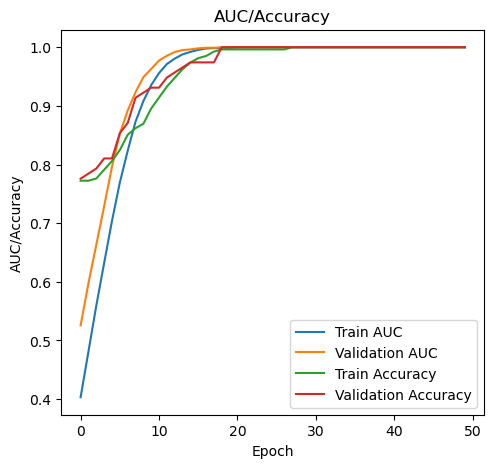

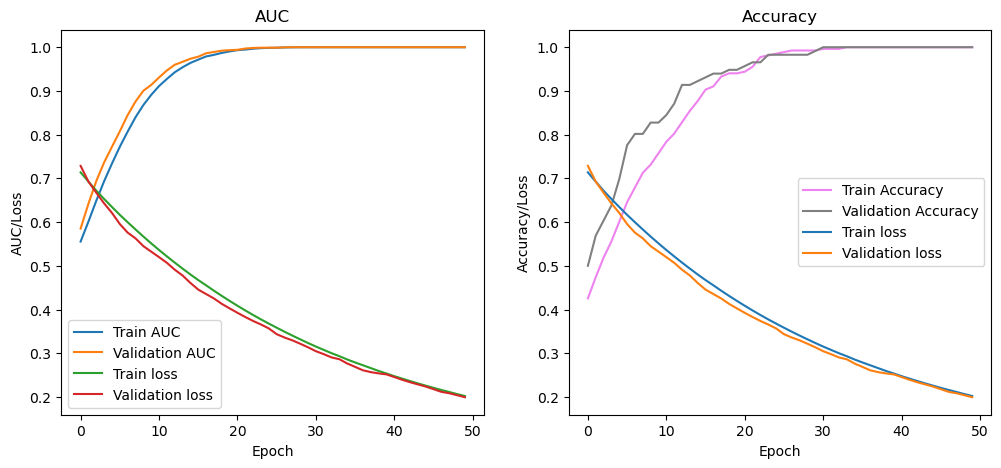

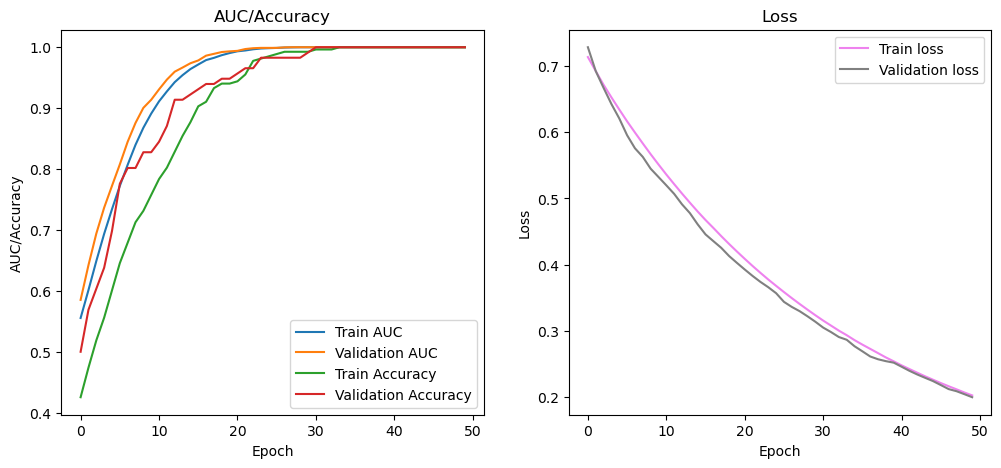

In [16]:
#MODELO CNN ALIMENTADO CON DATOS SINUSOIDALES 

# Reorganizar la matriz de entrada para que tenga una dimensión adicional y luego dividir en conjunto de entrenamiento y prueba
matriz1 = matriz1.reshape(matriz1.shape[0], matriz1.shape[1], 1)
x_tr, x_te, y_tr, y_te = train_test_split(matriz1, etiquetas1, test_size=0.3, stratify=y, shuffle=True) 
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

# Calcular pesos de clase para abordar el desequilibrio de clases
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))
print(class_weights)

# Definir la forma de entrada y otros parámetros del modelo
batch_size = 1
length = x_tr.shape[1]
chanels = x_tr.shape[2]
n_clases = 1
input_shape = (length,chanels)

# Definir el modelo
model = keras.Sequential()
model.add(keras.layers.Conv1D(3, 2, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0)))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_clases, activation='sigmoid'))
print(model.summary())

# Compilar el modelo con función de pérdida, optimizador y métricas de evaluación
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]


# Entrenar el modelo y guardar el historial de entrenamiento
history = model.fit(x_tr, y_tr, batch_size=32, validation_split=0.3, epochs=50, class_weight=class_weights, callbacks=callbacks)

# Predecir las etiquetas de prueba y calcular la precisión y el AUC
y_pred = model.predict_classes(x_te)
accuracy = metrics.accuracy_score(y_te, y_pred)
AUC = metrics.roc_auc_score(y_te, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC: %.2f%%" % (AUC * 100.0))

# Imprimir las etiquetas esperadas y las etiquetas predichas
for i in range(len(y_pred)):
    print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
    
# Visualizar el historial de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("AUC")
plt.ylabel("AUC/Loss")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_senos_AUC.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_senos_ACC.pdf')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("AUC/Accuracy")
plt.ylabel("AUC/Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
plt.savefig('imagenes/Tiempo_senos.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='violet')
plt.plot(history.history["val_loss"], color='grey')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_senos_Loss.pdf')

plt.show()

**TIEMPO CTG CNN**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(384, 4800, 2) (165, 4800, 2) (384,) (165,)
{0.0: 0.617363344051447, 1.0: 2.6301369863013697}
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 4799, 3)           15        
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2399, 3)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 7197)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 7198      
Total params: 7,213
Trainable params: 7,213
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
9/9 [==============================] - 0s 50ms/ste

9/9 [==============================] - 0s 13ms/step - loss: 0.5362 - accuracy: 0.8396 - auc: 0.9079 - val_loss: 0.7564 - val_accuracy: 0.6207 - val_auc: 0.5134
Epoch 90/100
9/9 [==============================] - 0s 12ms/step - loss: 0.5334 - accuracy: 0.8284 - auc: 0.9114 - val_loss: 0.7692 - val_accuracy: 0.6379 - val_auc: 0.5110
Epoch 91/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5302 - accuracy: 0.8358 - auc: 0.9117 - val_loss: 0.7375 - val_accuracy: 0.6466 - val_auc: 0.5090
Epoch 92/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5288 - accuracy: 0.8657 - auc: 0.9155 - val_loss: 0.7487 - val_accuracy: 0.6379 - val_auc: 0.5088
Epoch 93/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5269 - accuracy: 0.8619 - auc: 0.9153 - val_loss: 0.7498 - val_accuracy: 0.6466 - val_auc: 0.5090
Epoch 94/100
9/9 [==============================] - 0s 13ms/step - loss: 0.5262 - accuracy: 0.8284 - auc: 0.9152 - val_loss: 0.7595 - val_accuracy: 

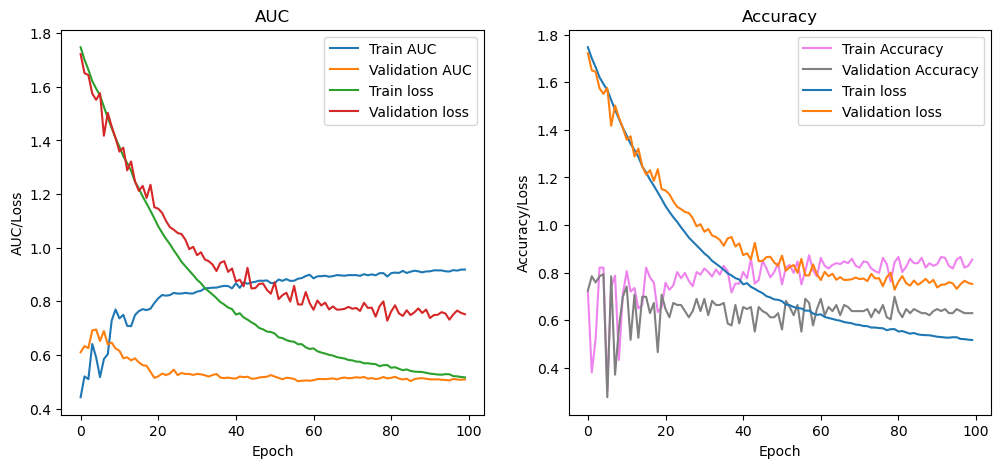

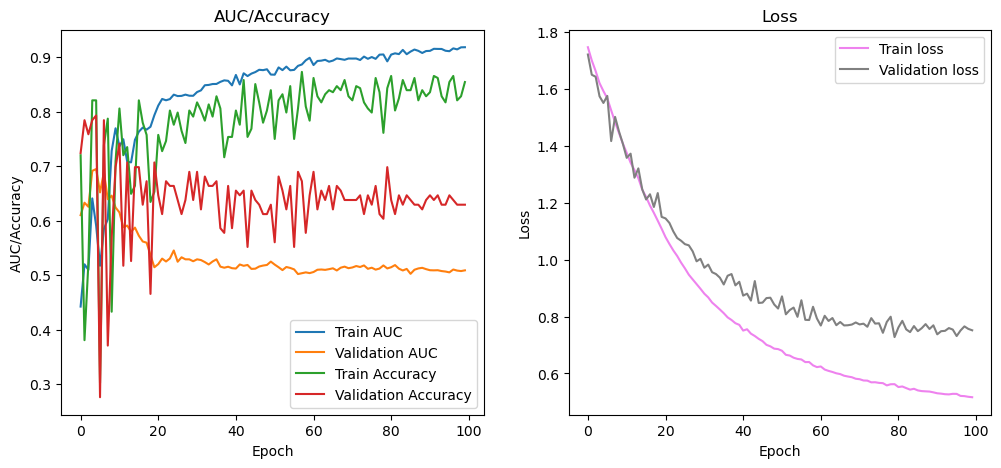

In [18]:
#MODELO CNN ALIMENTADO CON DATOS DE CTG
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos = target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

x_tr, x_te, y_tr, y_te = train_test_split(matriz, y, test_size=0.3, stratify=y, shuffle=True) 
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape )

from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))
print(class_weights)

x_tr[:,:,0]=x_tr[:,:,0]/300
x_tr[:,:,1]=x_tr[:,:,1]/300

x_te[:,:,0]=x_te[:,:,0]/300
x_te[:,:,1]=x_te[:,:,1]/300

batch_size = 1
length = x_tr.shape[1]
chanels = x_tr.shape[2]
n_clases = 1

input_shape = (length,chanels)

model = keras.Sequential()
model.add(keras.layers.Conv1D(3, 2, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0.5))) #kernel_regularizer=regularizers.l2(l=0.2)
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_clases, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'AUC'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]

history = model.fit(x_tr, y_tr, batch_size=32,  validation_split=0.3, epochs=100, class_weight=class_weights, callbacks=callbacks)
y_pred = model.predict_classes(x_te)

accuracy = metrics.accuracy_score(y_te, y_pred)
AUC = metrics.roc_auc_score(y_te, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC: %.2f%%" % (AUC * 100.0))
for i in range(len(y_pred)):
     print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("AUC")
plt.ylabel("AUC/Loss")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_AUC.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_ACC.pdf')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("AUC/Accuracy")
plt.ylabel("AUC/Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
plt.savefig('imagenes/T_senos.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='violet')
plt.plot(history.history["val_loss"], color='grey')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"])
plt.savefig('imagenes/Tiempo_Loss.pdf')

plt.show()

**FOURIER CNN**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 595, 5)            55        
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 297, 5)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1485)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 1486      
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________
N

Epoch 41/100
13/13 [==============================] - 0s 6ms/step - loss: 0.6248 - accuracy: 0.7579 - auc: 0.7544 - val_loss: 0.6571 - val_accuracy: 0.6699 - val_auc: 0.6228
Epoch 42/100
13/13 [==============================] - 0s 6ms/step - loss: 0.6219 - accuracy: 0.7653 - auc: 0.7571 - val_loss: 0.6437 - val_accuracy: 0.6796 - val_auc: 0.6163
Epoch 43/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6217 - accuracy: 0.7604 - auc: 0.7486 - val_loss: 0.6401 - val_accuracy: 0.6796 - val_auc: 0.6216
Epoch 44/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6187 - accuracy: 0.7677 - auc: 0.7533 - val_loss: 0.6377 - val_accuracy: 0.6893 - val_auc: 0.6247
Epoch 45/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6198 - accuracy: 0.7335 - auc: 0.7472 - val_loss: 0.6433 - val_accuracy: 0.6796 - val_auc: 0.6328
Epoch 46/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6164 - accuracy: 0.7848 - auc: 0.7538 - val_loss: 0.63

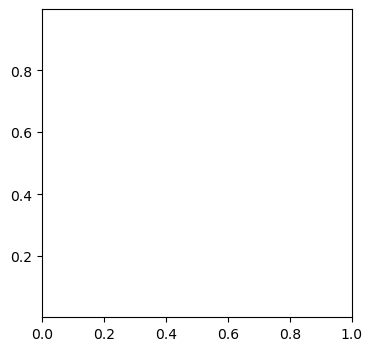

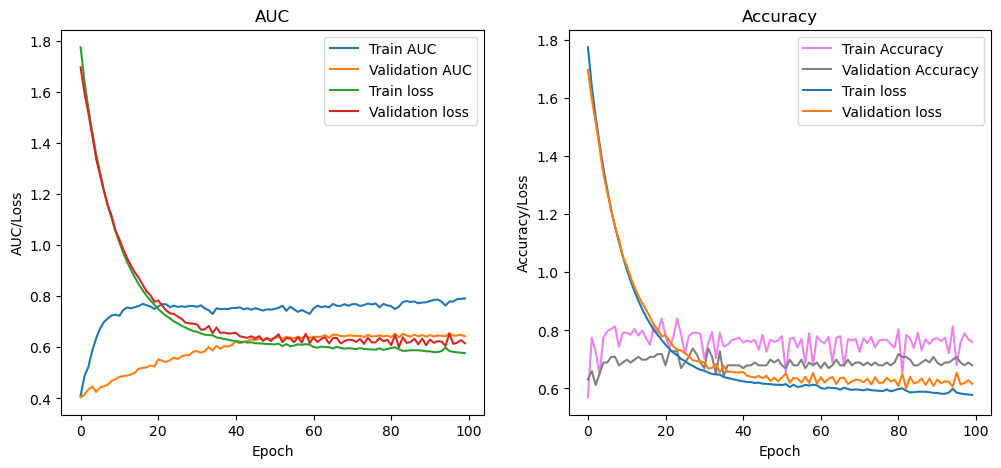

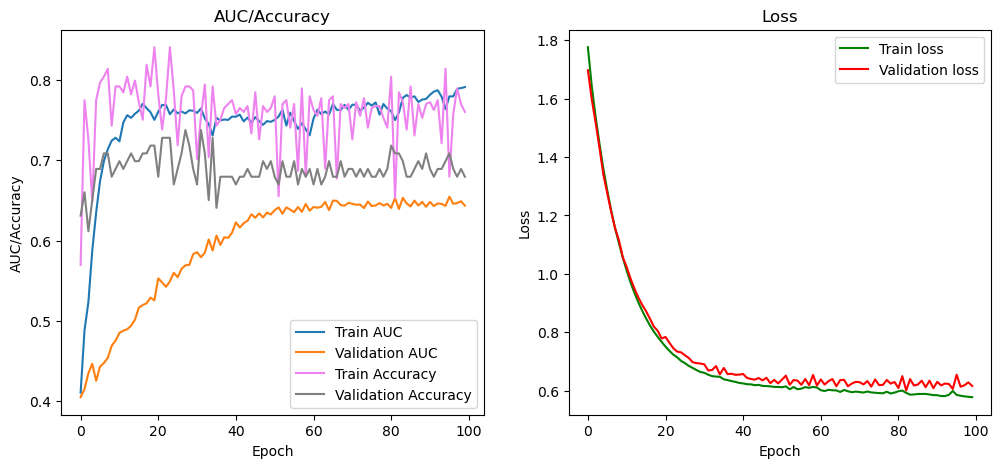

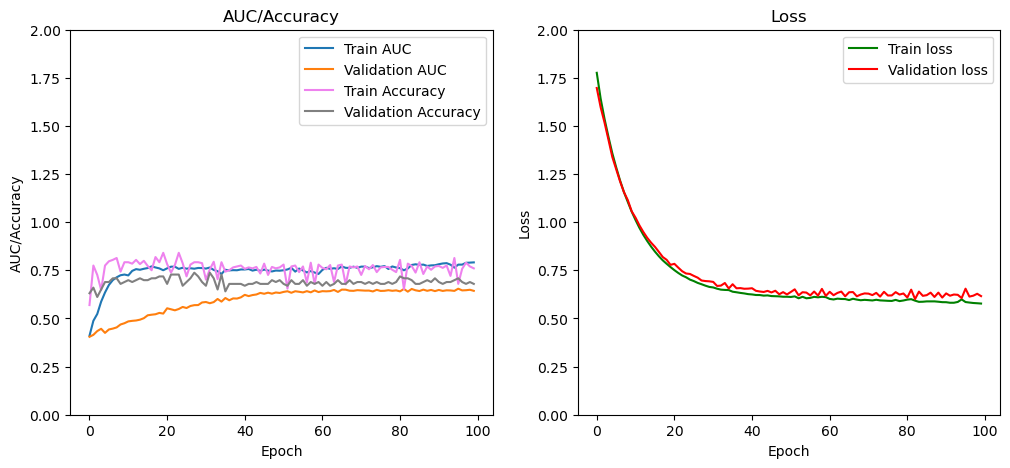

(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)


In [30]:
# MODELO CNN ALIMENTADO CON LA FTT DE LAS SEÑALES CTG
# Cargamos los datos de la matriz de señales y etiquetas
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
# Nos quedamos con las últimas 4800 muestras de cada señal
matriz = matriz[:,-4800:,:].astype("float32")
# Convertimos las etiquetas a 0 o 1 según un umbral
y, neg, pos = target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

# Calculamos la transformada de Fourier de las señales
matriz_f = fourier(matriz)

# Fijamos la semilla para asegurar la reproducibilidad de los resultados
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Definimos una estrategia de validación cruzada estratificada
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
# Inicializamos los contadores
fold_num = 1
num = 0

# Iteramos sobre cada conjunto de entrenamiento y prueba generado por la estrategia de validación cruzada
for train_index, test_index in skf.split(matriz_f, y):
    # Seleccionar los conjuntos de entrenamiento y prueba
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    #Seleccionamos la partición número 4 que es con la que hemos obtenido mejor rendimiento
    if fold_num == 4:
        # Configurar los pesos de clase para abordar el desequilibrio de clase en el conjunto de entrenamiento
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))
        
        # Definir la forma de entrada del modelo
        batch_size = 1
        length = x_tr.shape[1]
        chanels = x_tr.shape[2]
        n_clases = 1

        input_shape = (length,chanels)

        # Crear el modelo
        model = keras.Sequential()
        model.add(keras.layers.Conv1D(5, 5, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0.5))) #kernel_regularizer=regularizers.l2(l=0.2)
        model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(n_clases, activation='sigmoid'))
        print(model.summary())
        
        # Compilar el modelo
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'AUC'])
        # Definir una lista de callbacks, que se llamarán durante el entrenamiento del modelo
        callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]
        
        # Entrenar el modelo
        history = model.fit(x_tr, y_tr, batch_size=32,  validation_split=0.2, epochs=100, class_weight=class_weights, callbacks=callbacks)
        # Calcular las predicciones en el conjunto de prueba
        y_pred = model.predict_classes(x_te)

        # Calcular la precisión y el AUC 
        accuracy = metrics.accuracy_score(y_te, y_pred)
        AUC = metrics.roc_auc_score(y_te, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("AUC: %.2f%%" % (AUC * 100.0))
        # Imprimir las etiquetas esperadas y las etiquetas predichas
        for i in range(len(y_pred)):
             print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
        # Graficar las curvas de aprendizaje
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/FFT_AUC.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/FFT_ACC.pdf')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/FFT.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/FFT_Loss.pdf')

        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"] )
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.ylim([0,2])
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/FFT_LIM.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.ylim([0,2])
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/FFT_Loss_LIM.pdf')

        plt.show()
    fold_num = fold_num + 1 

**VENTANAS CNN**

(549, 4409, 2) (549, 4409, 2)
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 546, 5)            55        
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 273, 5)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1365)              0         
_________________________________________________________

24/24 [==============================] - 0s 6ms/step - loss: 0.6646 - accuracy: 0.5638 - auc: 0.6409 - val_loss: 0.7257 - val_accuracy: 0.4844 - val_auc: 0.7060
Epoch 88/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6664 - accuracy: 0.6680 - auc: 0.6326 - val_loss: 0.7456 - val_accuracy: 0.4414 - val_auc: 0.7052
Epoch 89/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6622 - accuracy: 0.5977 - auc: 0.6474 - val_loss: 0.7006 - val_accuracy: 0.5391 - val_auc: 0.7018
Epoch 90/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.6328 - auc: 0.6463 - val_loss: 0.7144 - val_accuracy: 0.5039 - val_auc: 0.7034
Epoch 91/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6646 - accuracy: 0.7188 - auc: 0.6422 - val_loss: 0.7355 - val_accuracy: 0.4609 - val_auc: 0.7044
Epoch 92/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.5755 - auc: 0.6465 - val_loss: 0.7037 - val_accu

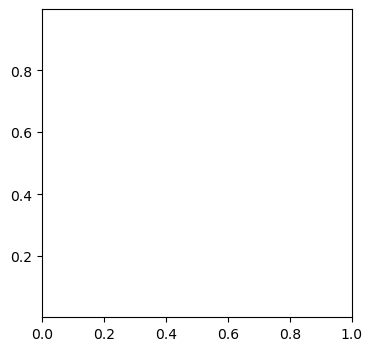

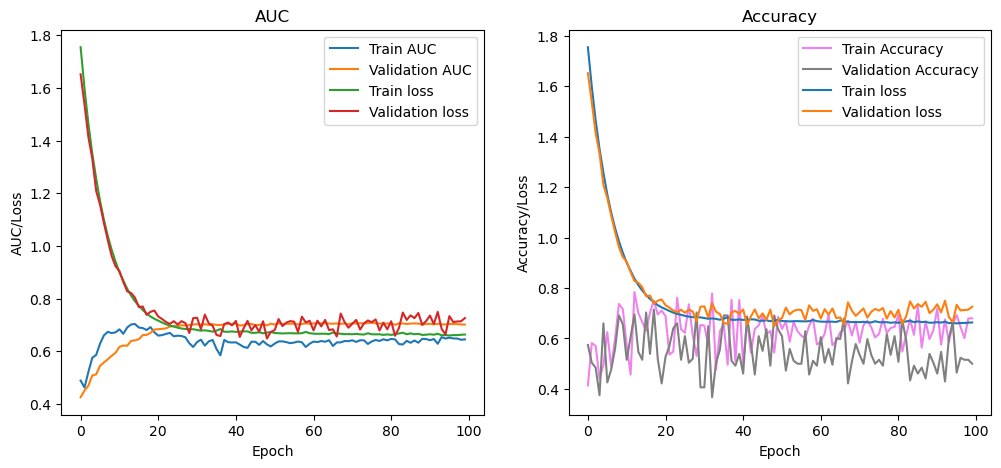

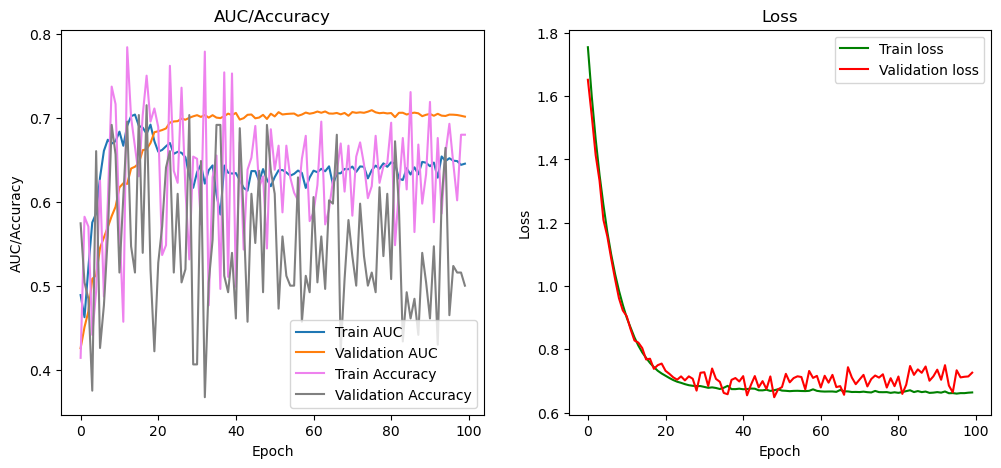

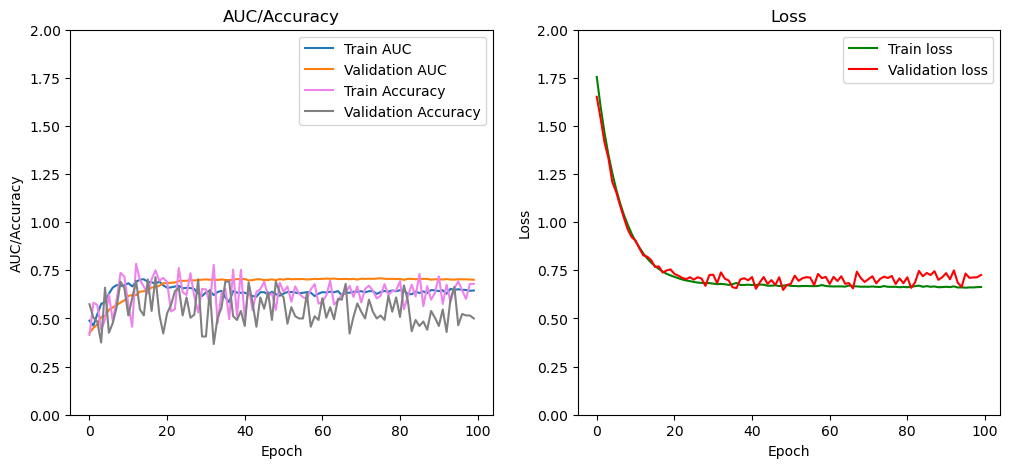

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)


In [27]:
#MODELO CNN ALIMENTADO CON LA FTT DE LAS SEÑALES AUMENTADAS
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
matriz = matriz.astype("float32")
matriz_1 = matriz[:,0:matriz.shape[1]//2:,:]
matriz_2 = matriz[:,matriz.shape[1]//2:,:]  
print(matriz_1.shape, matriz_2.shape)
y_1, neg_1, pos_1 =  target(etiqueta, 7.15)
y_2, neg_2, pos_2 =  target(etiqueta, 7.15)
y_1 = y_1.astype("float32").reshape(-1)
y_2 = y_2.astype("float32").reshape(-1)

matriz_f_1 = fourier(matriz_1)
matriz_f_2 = fourier(matriz_2)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
num = 0

for train_index, test_index in skf.split(matriz_f_1, y_1):
    x_tr= np.concatenate((matriz_f_1[train_index, 1:matriz_f_1.shape[1]//4, :], 
                      matriz_f_2[train_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_tr = np.concatenate((y_1[train_index], y_2[train_index]), axis=0)
    x_te= np.concatenate((matriz_f_1[test_index, 1:matriz_f_1.shape[1]//4, :], 
                      matriz_f_2[test_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_te = np.concatenate((y_1[test_index], y_2[test_index]), axis=0)
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    if fold_num == 6:
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))

        batch_size = 1
        length = x_tr.shape[1]
        chanels = x_tr.shape[2]
        n_clases = 1

        input_shape = (length,chanels)
        model = keras.Sequential()
        model.add(keras.layers.Conv1D(5, 5, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0.5))) #kernel_regularizer=regularizers.l2(l=0.2)
        model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(n_clases, activation='sigmoid'))
        print(model.summary())
        
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0008), metrics=['accuracy', 'AUC'])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]
       
        history = model.fit(x_tr, y_tr, batch_size=32,  validation_split=0.25, epochs=100, class_weight=class_weights, callbacks=callbacks)
        y_pred = model.predict_classes(x_te)

        accuracy = metrics.accuracy_score(y_te, y_pred)
        AUC = metrics.roc_auc_score(y_te, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("AUC: %.2f%%" % (AUC * 100.0))
        for i in range(len(y_pred)):
             print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
                
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/V_AUC.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/V_ACC.pdf')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/V.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/V_Loss.pdf')

        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"] )
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.ylim([0,2])
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/V_LIM.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.ylim([0,2])
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/V_Loss_LIM.pdf')

        plt.show()
    fold_num = fold_num + 1 

**LSTM**

In [2]:
#GERAMOS DATOS SINUSOIDALES 
matriz1 = np.zeros((len(y), 4800))
etiquetas1 = np.zeros((len(y)))
for i in range(neg):                   
    matriz1[i] = np.sin(np.arange(0,4800)*(np.pi*2/20) + np.random.randn(4800))
    etiquetas1[i] = 0
for i in range(neg, neg+pos):    
    matriz1[i] = np.cos(np.arange(0,4800)*(np.pi*2/20) + np.random.randn(4800))
    etiquetas1[i] = 1
matriz1.shape, etiquetas1.shape, matriz1.max(), matriz1.min(), etiquetas1

((549, 4800),
 (549,),
 0.9999999999999497,
 -0.9999999999999976,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

(384, 4800, 1) (165, 4800, 1) (384,) (165,)
{0.0: 0.6114649681528662, 1.0: 2.742857142857143}
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 20)                1760      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 20)                80        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 1,861
Trainable params: 1,821
Non-trainable params: 40
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 1.0460 - accuracy: 0.2801 - auc: 0.1125 - val_loss: 0.6730 - val_accuracy: 0.88

Epoch 91/100
5/5 [==============================] - 6s 1s/step - loss: 0.0394 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0104 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 92/100
5/5 [==============================] - 6s 1s/step - loss: 0.0334 - accuracy: 0.9967 - auc: 1.0000 - val_loss: 0.0718 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 93/100
5/5 [==============================] - 6s 1s/step - loss: 0.0344 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0386 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 94/100
5/5 [==============================] - 6s 1s/step - loss: 0.0354 - accuracy: 0.9967 - auc: 1.0000 - val_loss: 0.0293 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 95/100
5/5 [==============================] - 6s 1s/step - loss: 0.0279 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0327 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 96/100
5/5 [==============================] - 6s 1s/step - loss: 0.0259 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0107 - val_accuracy:

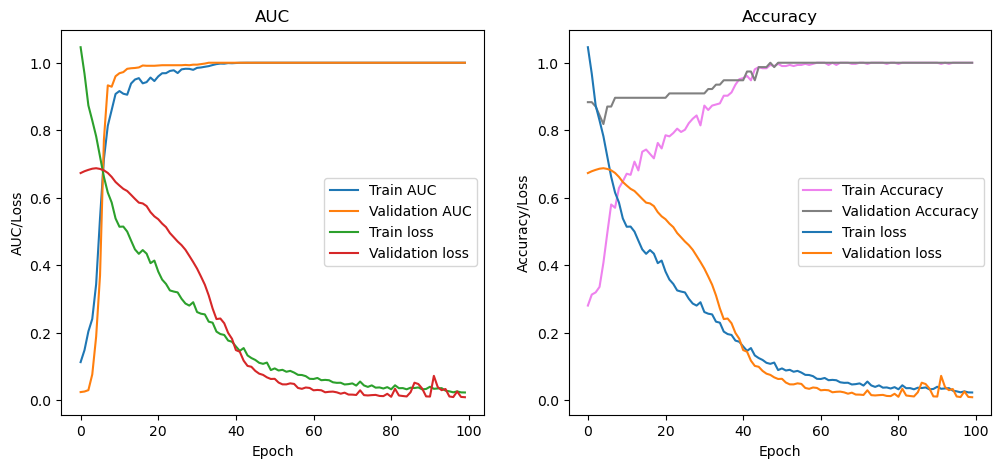

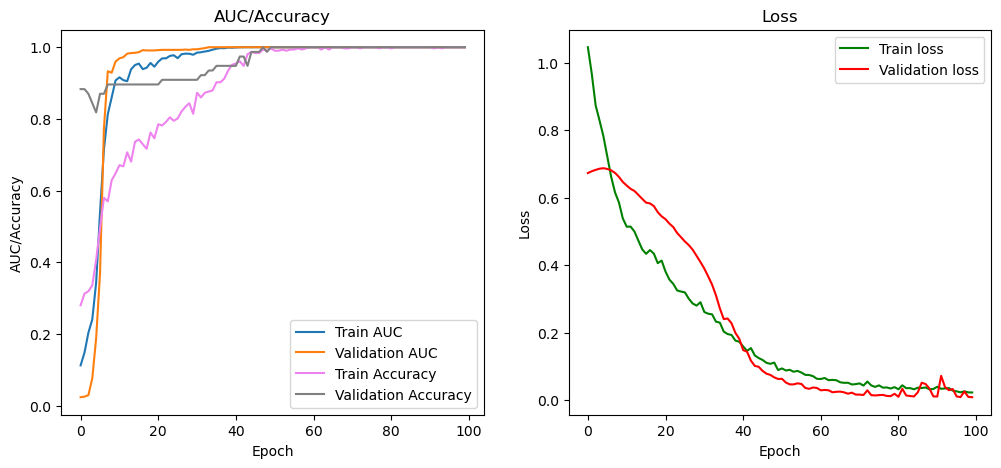

In [13]:
# MODELO LSTM ALIMENTADO CON DATOS SINUSOIDALES
matriz1 = matriz1.reshape(matriz1.shape[0], matriz1.shape[1], 1)
x_tr, x_te, y_tr, y_te = train_test_split(matriz1, etiquetas1, test_size=0.3, stratify=y, shuffle=True) 
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape )

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))
print(class_weights)

batch_size = 1
length = x_tr.shape[1]
chanels = x_tr.shape[2]
n_clases = 1

input_shape = (length,chanels)

model = keras.Sequential()
model.add(keras.layers.LSTM(20, input_shape=input_shape, activation='relu'))
model.add(keras.layers.Dropout(0.05))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0008), metrics=['accuracy', 'AUC'])

history = model.fit(x_tr, y_tr, batch_size=64,  validation_split=0.2, epochs=100, class_weight=class_weights)
y_pred = model.predict_classes(x_te)

accuracy = metrics.accuracy_score(y_te, y_pred)
AUC = metrics.roc_auc_score(y_te, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC: %.2f%%" % (AUC * 100.0))
for i in range(len(y_pred)):
     print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("AUC")
plt.ylabel("AUC/Loss")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_senos_aUC_1.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_senos_acc_1.pdf')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.title("AUC/Accuracy")
plt.ylabel("AUC/Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
plt.savefig('imagenes/LSTM_tiempo_senos_1.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='green')
plt.plot(history.history["val_loss"], color='red')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_senos_Loss_1.pdf')

plt.show()

**LSTM TIEMPO**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(384, 4800, 2) (165, 4800, 2) (384,) (165,)
{0.0: 0.617363344051447, 1.0: 2.6301369863013697}
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 40)                6880      
_________________________________________________________________
batch_normalization_14 (Batc (None, 40)                160       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 41        
Total params: 7,081
Trainable params: 7,001
Non-trainable params: 80
_________________________________________________________________
None
Epoch 1/100
5/5 [==============================] - 11s 2s/step - loss: 0.6971 - accuracy: 0.3806 - auc: 0.4643 - val_loss: 0.6890 - val_accuracy: 0.8103 - val_auc: 0.4715
Epoch 2/100
5/5 [=====

Epoch 91/100
5/5 [==============================] - 11s 2s/step - loss: 0.6299 - accuracy: 0.6418 - auc: 0.6987 - val_loss: 0.6907 - val_accuracy: 0.6207 - val_auc: 0.4587
Epoch 92/100
5/5 [==============================] - 10s 2s/step - loss: 0.6321 - accuracy: 0.6455 - auc: 0.6920 - val_loss: 0.6503 - val_accuracy: 0.7328 - val_auc: 0.4294
Epoch 93/100
5/5 [==============================] - 10s 2s/step - loss: 0.6319 - accuracy: 0.6269 - auc: 0.6971 - val_loss: 0.6158 - val_accuracy: 0.7586 - val_auc: 0.4076
Epoch 94/100
5/5 [==============================] - 11s 2s/step - loss: 0.6433 - accuracy: 0.6082 - auc: 0.6751 - val_loss: 0.6262 - val_accuracy: 0.7241 - val_auc: 0.4352
Epoch 95/100
5/5 [==============================] - 11s 2s/step - loss: 0.6395 - accuracy: 0.6343 - auc: 0.6719 - val_loss: 0.6759 - val_accuracy: 0.6207 - val_auc: 0.4666
Epoch 96/100
5/5 [==============================] - 11s 2s/step - loss: 0.6353 - accuracy: 0.6418 - auc: 0.6897 - val_loss: 0.6824 - val_acc

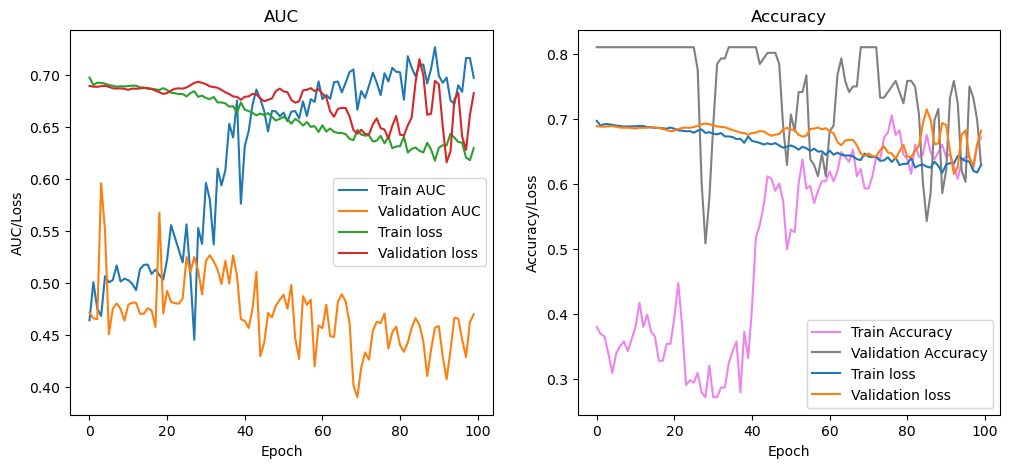

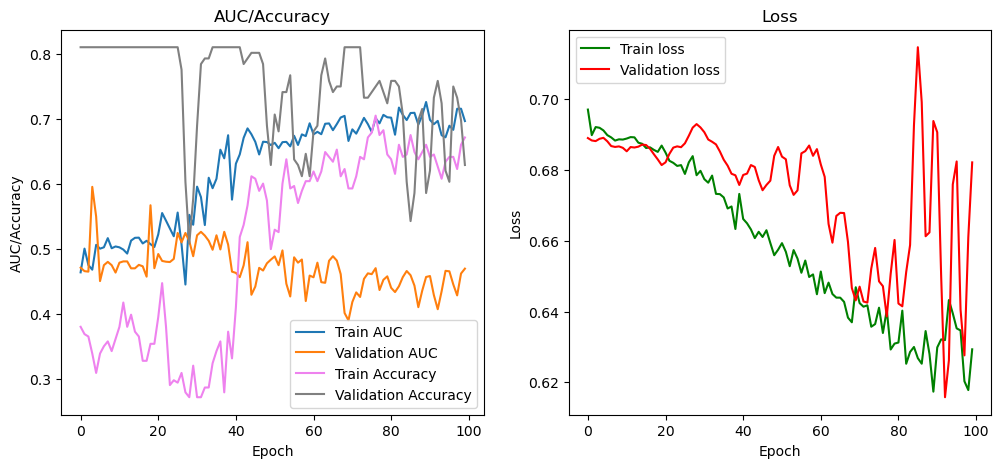

In [16]:
# MODELO LSTM ALIMENTADO CON LAS SEÑALES CTG
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

x_tr, x_te, y_tr, y_te = train_test_split(matriz, y, test_size=0.3, stratify=y, shuffle=True) 
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape )

from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))
print(class_weights)

x_tr[:,:,0]=x_tr[:,:,0]/250
x_tr[:,:,1]=x_tr[:,:,1]/250

x_te[:,:,0]=x_te[:,:,0]/250
x_te[:,:,1]=x_te[:,:,1]/250

batch_size = 1
length = x_tr.shape[1]
chanels = x_tr.shape[2]
n_clases = 1

input_shape = (length,chanels)


model = keras.Sequential()
model.add(keras.layers.LSTM(40, input_shape=input_shape, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0005), metrics=['accuracy', 'AUC'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]

history = model.fit(x_tr, y_tr, batch_size=64,  validation_split=0.3, epochs=100, class_weight=class_weights, callbacks=callbacks)
y_pred = model.predict_classes(x_te)

accuracy = metrics.accuracy_score(y_te, y_pred)
AUC = metrics.roc_auc_score(y_te, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AUC: %.2f%%" % (AUC * 100.0))
for i in range(len(y_pred)):
     print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("AUC")
plt.ylabel("AUC/Loss")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_aUC_2.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_acc_2.pdf')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.title("AUC/Accuracy")
plt.ylabel("AUC/Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
plt.savefig('imagenes/LSTM_tiempo_2.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='green')
plt.plot(history.history["val_loss"], color='red')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_tiempo_Loss_2.pdf')

plt.show()

**LSTM FOURIER**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
{0.0: 0.6165865384615384, 1.0: 2.6443298969072164}
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 20)                1840      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_____________________________

Epoch 40/70
9/9 [==============================] - 3s 363ms/step - loss: 0.6897 - accuracy: 0.5750 - auc: 0.5289 - val_loss: 0.6905 - val_accuracy: 0.6667 - val_auc: 0.6502
Epoch 41/70
9/9 [==============================] - 3s 364ms/step - loss: 0.6919 - accuracy: 0.5692 - auc: 0.5190 - val_loss: 0.6903 - val_accuracy: 0.6944 - val_auc: 0.6502
Epoch 42/70
9/9 [==============================] - 3s 367ms/step - loss: 0.6903 - accuracy: 0.5770 - auc: 0.5377 - val_loss: 0.6900 - val_accuracy: 0.6944 - val_auc: 0.6650
Epoch 43/70
9/9 [==============================] - 3s 371ms/step - loss: 0.6896 - accuracy: 0.5867 - auc: 0.5393 - val_loss: 0.6900 - val_accuracy: 0.6944 - val_auc: 0.6626
Epoch 44/70
9/9 [==============================] - 3s 380ms/step - loss: 0.6932 - accuracy: 0.5575 - auc: 0.5039 - val_loss: 0.6897 - val_accuracy: 0.6944 - val_auc: 0.6749
Epoch 45/70
9/9 [==============================] - 3s 363ms/step - loss: 0.6938 - accuracy: 0.5731 - auc: 0.5161 - val_loss: 0.6896 - v

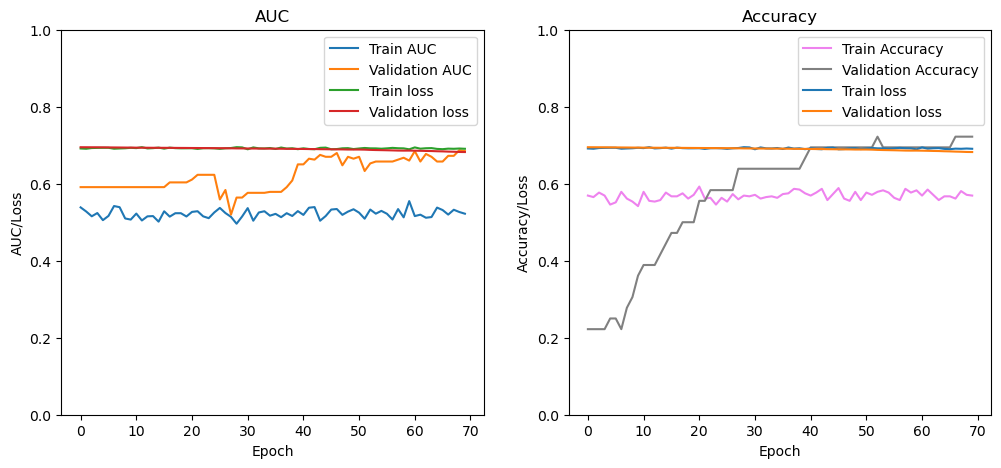

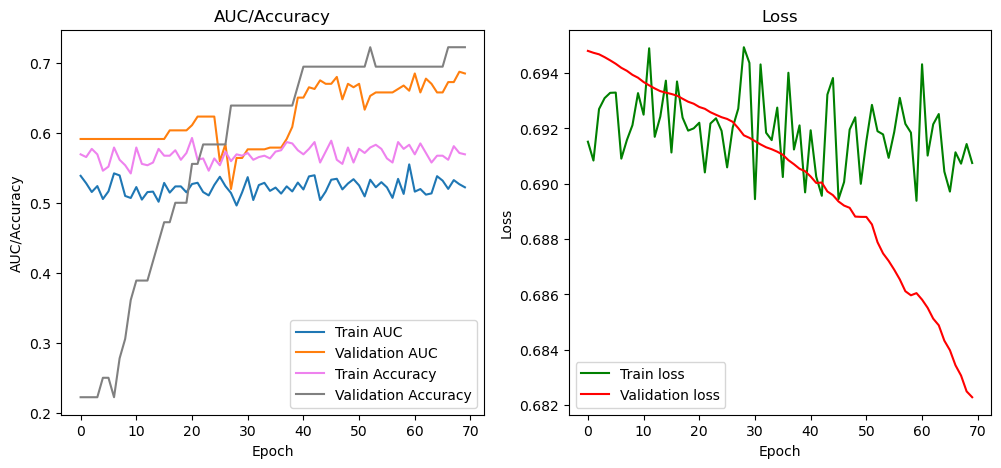

Test set accuracy score for best params in fold 12: 0.7222222222222222
Test set AUC score for best params in fold 12 : 0.6650246305418719

(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)


In [26]:
# MODELO LSTM ENTRENADO CON LA FTT DE LAS SEÑALES CTG
from keras.callbacks import ModelCheckpoint
matriz = matriz.astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

matriz = matriz[:,-4800:,:]
matriz_f = fourier(matriz)

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
num = 0

for train_index, test_index in skf.split(matriz, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    if fold_num == 12:
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))
        print(class_weights)
        batch_size = 1
        length = x_tr.shape[1]
        chanels = x_tr.shape[2]
        n_clases = 1

        input_shape = (length,chanels)


        model = keras.Sequential()
        model.add(keras.layers.LSTM(20, input_shape=input_shape, activation='relu', dropout=0.2, recurrent_dropout=0.2))
        model.add(keras.layers.Dropout(0))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        print(model.summary())
        
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
        model.load_weights('LSTM_F/pesos-01.h5')
        
        history = model.fit(x_tr, y_tr, epochs=70, batch_size=64, validation_data=(x_te, y_te), class_weight=class_weights)#
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_FFT_aUC_11.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_FFT_acc_11.pdf')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/LSTM_FFT_1.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_FFT_Loss_1.pdf')

        plt.show()
        
        y_pred = model.predict(x_te)
        score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
        
        print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
        print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')

    fold_num = fold_num +1    

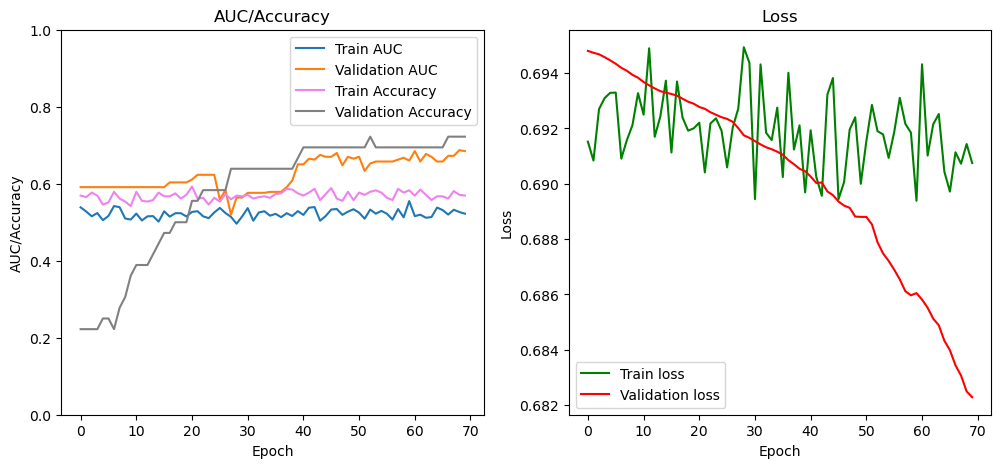

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.plot(history.history["accuracy"], color='violet')
plt.plot(history.history["val_accuracy"], color='grey')
plt.ylim([0,1])
plt.title("AUC/Accuracy")
plt.ylabel("AUC/Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
plt.savefig('imagenes/LSTM_FFT_2.pdf')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='green')
plt.plot(history.history["val_loss"], color='red')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss", "Validation loss"])
plt.savefig('imagenes/LSTM_FFT_Loss_2.pdf')

plt.show()

**LSTM VENTANAS**

(549, 4409, 2) (549, 4409, 2)
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
{0.0: 0.6168674698795181, 1.0: 2.6391752577319587}
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 40)                6880      
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 40)                160       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 7,081
Trainable params: 7,001

Epoch 41/70
16/16 [==============================] - 3s 202ms/step - loss: 0.6919 - accuracy: 0.4648 - auc: 0.5409 - val_loss: 0.6942 - val_accuracy: 0.4459 - val_auc: 0.6446
Epoch 42/70
16/16 [==============================] - 3s 205ms/step - loss: 0.6925 - accuracy: 0.4707 - auc: 0.5183 - val_loss: 0.6944 - val_accuracy: 0.4324 - val_auc: 0.6363
Epoch 43/70
16/16 [==============================] - 4s 229ms/step - loss: 0.6915 - accuracy: 0.4775 - auc: 0.5222 - val_loss: 0.6944 - val_accuracy: 0.4324 - val_auc: 0.6315
Epoch 44/70
16/16 [==============================] - 3s 208ms/step - loss: 0.6958 - accuracy: 0.4346 - auc: 0.4698 - val_loss: 0.6943 - val_accuracy: 0.4324 - val_auc: 0.6518
Epoch 45/70
16/16 [==============================] - 3s 210ms/step - loss: 0.6946 - accuracy: 0.4609 - auc: 0.5019 - val_loss: 0.6941 - val_accuracy: 0.4459 - val_auc: 0.6565
Epoch 46/70
16/16 [==============================] - 3s 208ms/step - loss: 0.6933 - accuracy: 0.4854 - auc: 0.5038 - val_loss

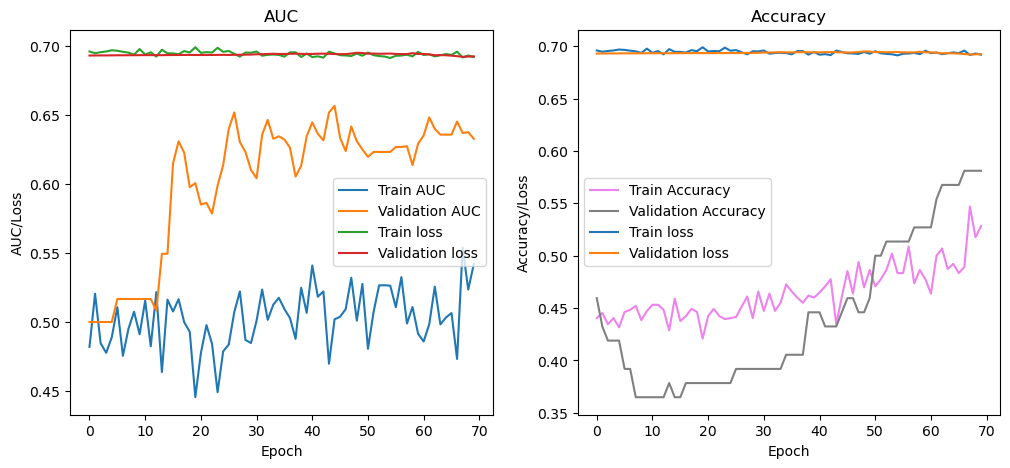

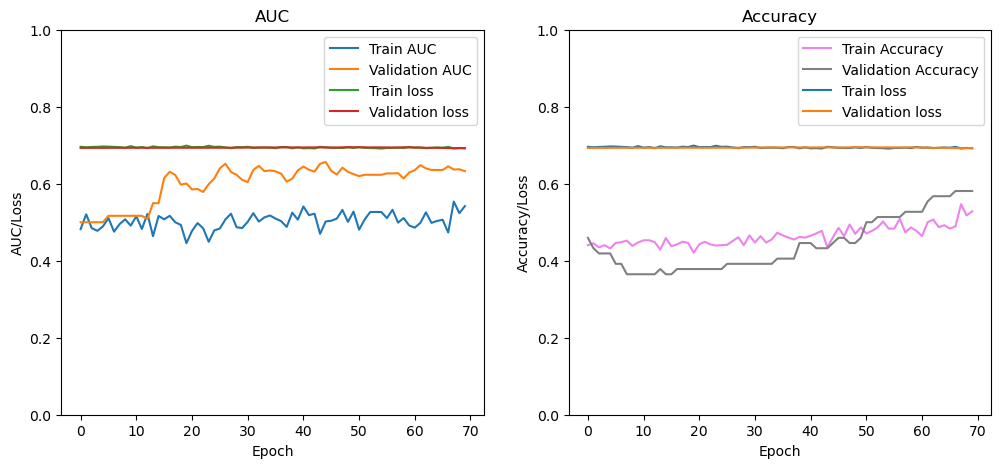

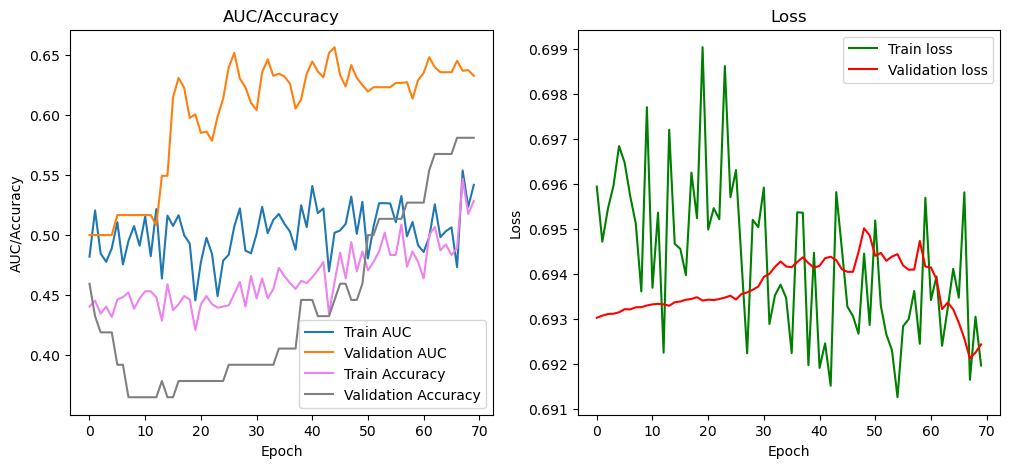

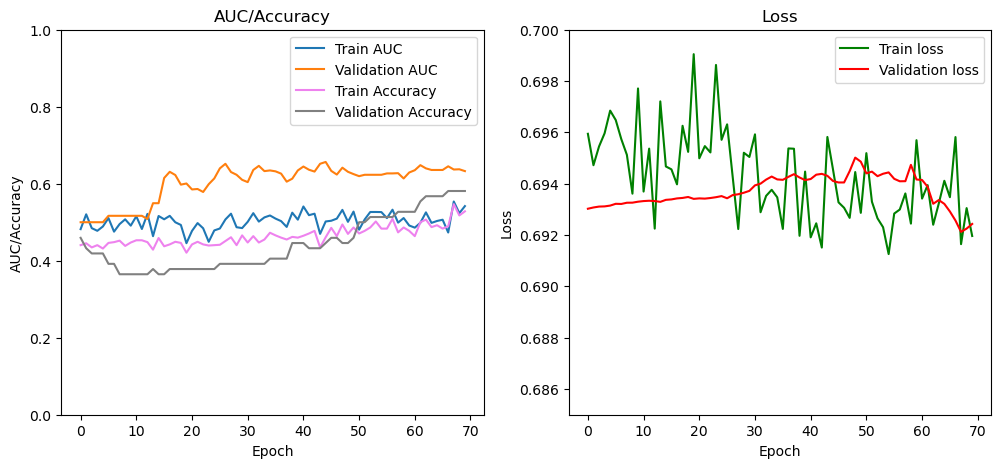

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)


In [29]:
# MODELO LSTM ENTRENADO CON LA FTT DE LAS SEÑALES AUMENTADAS
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
from keras.callbacks import ModelCheckpoint
matriz = matriz.astype("float32")
matriz_1 = matriz[:,0:matriz.shape[1]//2:,:]
matriz_2 = matriz[:,matriz.shape[1]//2:,:]  
print(matriz_1.shape, matriz_2.shape)
y_1, neg_1, pos_1 =  target(etiqueta, 7.15)
y_2, neg_2, pos_2 =  target(etiqueta, 7.15)
y_1 = y_1.astype("float32").reshape(-1)
y_2 = y_2.astype("float32").reshape(-1)

matriz_f_1 = fourier(matriz_1)
matriz_f_2 = fourier(matriz_2)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
num = 1

for train_index, test_index in skf.split(matriz_f_1, y_1):
    x_tr= np.concatenate((matriz_f_1[train_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[train_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_tr = np.concatenate((y_1[train_index], y_2[train_index]), axis=0)
    x_te= np.concatenate((matriz_f_1[test_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[test_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_te = np.concatenate((y_1[test_index], y_2[test_index]), axis=0)
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    if fold_num == 2:
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))
        print(class_weights)

        batch_size = 1
        length = x_tr.shape[1]
        chanels = x_tr.shape[2]
        n_clases = 1

        input_shape = (length,chanels)

        model = keras.Sequential()
        model.add(keras.layers.LSTM(40, input_shape=input_shape, activation='relu', dropout=0.2, recurrent_dropout=0.2))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        print(model.summary())
        
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]
        
        history = model.fit(x_tr, y_tr, batch_size=64,  validation_data=(x_te, y_te), epochs=70, 
                            class_weight=class_weights, callbacks=callbacks)
        y_pred = model.predict_classes(x_te)

        accuracy = metrics.accuracy_score(y_te, y_pred)
        AUC = metrics.roc_auc_score(y_te, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("AUC: %.2f%%" % (AUC * 100.0))
        for i in range(len(y_pred)):
             print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_aUC.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_acc_11.pdf')
        plt.show()
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_aUC_11.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_acc.pdf')
        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/LSTM_V.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_Loss.pdf')
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.ylim([0,1])
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/LSTM_V_1.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.ylim([0.685,0.7])
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTM_V_Loss_11.pdf')

        

        plt.show()


    fold_num = fold_num +1 

**CNN PROFUNDO**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 597, 8)            56        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 5)            85        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 5

16/16 [==============================] - 0s 7ms/step - loss: 2.0511 - accuracy: 0.6602 - auc: 0.7048 - val_loss: 2.0194 - val_accuracy: 0.6757 - val_auc: 0.8762
Epoch 86/200
16/16 [==============================] - 0s 7ms/step - loss: 2.0335 - accuracy: 0.6562 - auc: 0.7115 - val_loss: 2.0040 - val_accuracy: 0.6757 - val_auc: 0.8762
Epoch 87/200
16/16 [==============================] - 0s 7ms/step - loss: 2.0186 - accuracy: 0.6641 - auc: 0.7131 - val_loss: 1.9867 - val_accuracy: 0.6757 - val_auc: 0.8786
Epoch 88/200
16/16 [==============================] - 0s 7ms/step - loss: 2.0047 - accuracy: 0.6621 - auc: 0.7119 - val_loss: 1.9725 - val_accuracy: 0.6757 - val_auc: 0.8786
Epoch 89/200
16/16 [==============================] - 0s 6ms/step - loss: 1.9917 - accuracy: 0.6582 - auc: 0.7073 - val_loss: 1.9586 - val_accuracy: 0.6757 - val_auc: 0.8810
Epoch 90/200
16/16 [==============================] - 0s 7ms/step - loss: 1.9794 - accuracy: 0.6543 - auc: 0.6977 - val_loss: 1.9446 - val_accu

Epoch 132/200
16/16 [==============================] - 0s 7ms/step - loss: 1.4575 - accuracy: 0.7012 - auc: 0.7616 - val_loss: 1.4248 - val_accuracy: 0.7568 - val_auc: 0.9524
Epoch 133/200
16/16 [==============================] - 0s 7ms/step - loss: 1.4480 - accuracy: 0.7129 - auc: 0.7617 - val_loss: 1.4149 - val_accuracy: 0.7568 - val_auc: 0.9524
Epoch 134/200
16/16 [==============================] - 0s 6ms/step - loss: 1.4387 - accuracy: 0.7090 - auc: 0.7620 - val_loss: 1.4060 - val_accuracy: 0.7568 - val_auc: 0.9524
Epoch 135/200
16/16 [==============================] - 0s 7ms/step - loss: 1.4266 - accuracy: 0.6914 - auc: 0.7670 - val_loss: 1.3872 - val_accuracy: 0.7568 - val_auc: 0.9524
Epoch 136/200
16/16 [==============================] - 0s 7ms/step - loss: 1.4261 - accuracy: 0.6973 - auc: 0.7428 - val_loss: 1.3787 - val_accuracy: 0.7568 - val_auc: 0.9524
Epoch 137/200
16/16 [==============================] - 0s 6ms/step - loss: 1.4119 - accuracy: 0.7109 - auc: 0.7602 - val_loss

Epoch 179/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0852 - accuracy: 0.7207 - auc: 0.7791 - val_loss: 1.0170 - val_accuracy: 0.7838 - val_auc: 0.9619
Epoch 180/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0806 - accuracy: 0.7266 - auc: 0.7759 - val_loss: 1.0102 - val_accuracy: 0.7838 - val_auc: 0.9619
Epoch 181/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0727 - accuracy: 0.7051 - auc: 0.7812 - val_loss: 1.0018 - val_accuracy: 0.7838 - val_auc: 0.9619
Epoch 182/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0676 - accuracy: 0.7148 - auc: 0.7812 - val_loss: 0.9960 - val_accuracy: 0.7838 - val_auc: 0.9619
Epoch 183/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0698 - accuracy: 0.7305 - auc: 0.7689 - val_loss: 0.9921 - val_accuracy: 0.7838 - val_auc: 0.9595
Epoch 184/200
16/16 [==============================] - 0s 7ms/step - loss: 1.0507 - accuracy: 0.7383 - auc: 0.7924 - val_loss

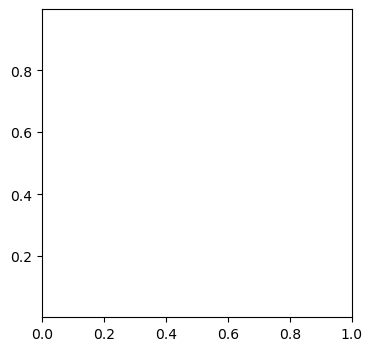

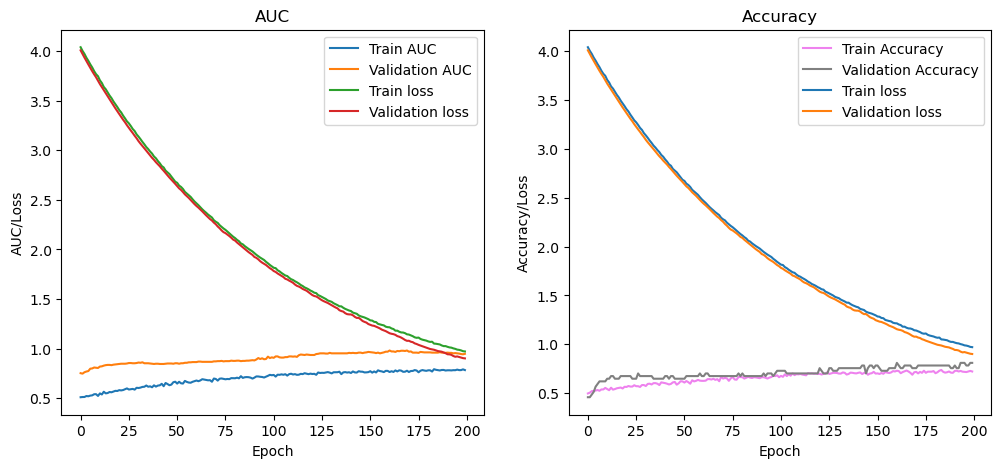

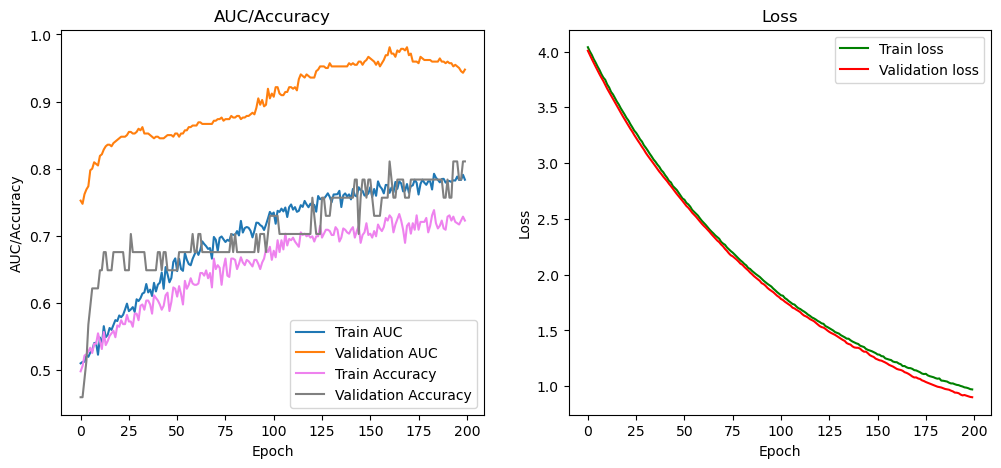

(512, 599, 2) (37, 599, 2) (512,) (37,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)


In [35]:
# MODELO CNN PROFUNDO ENTRENADO CON LA FTT DE LAS SEÑALES
from keras.wrappers.scikit_learn import KerasRegressor
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)
matriz_f = fourier(matriz)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1

num = 0
for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    if fold_num == 8:
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))

        batch_size = 1
        length = x_tr.shape[1]
        chanels = x_tr.shape[2]
        n_clases = 1

        input_shape = (length,chanels)

        model = Sequential()
        
        # 1 Convolution layer with Max polling
        model.add(Conv1D(8, 3, strides=1, activation='relu', input_shape=input_shape,
                         kernel_regularizer=regularizers.l2(l=0.5))) #kernel_regularizer=regularizers.l2(l=0.2)
        model.add(keras.layers.MaxPooling1D(3))
        model.add(Conv1D(5, 2, strides=1, activation='relu', kernel_regularizer=regularizers.l2(l=0.3)))
        model.add(keras.layers.MaxPooling1D(2))
        
        # 2 Flatten layer
        model.add(Flatten())
        
        # 1 Full connected layer
        model.add(keras.layers.BatchNormalization())
        model.add(Dense(1, activation = 'sigmoid')) # 2 classes
        print(model.summary())
        
        #compile model
        model.load_weights('Definitivo/CNN/profundo/8_pesos-01.h5')
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy', 'AUC'])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_auc', save_best_only=True)]
        
        history = model.fit(x_tr, y_tr, batch_size=32,  validation_data = (x_te, y_te), epochs=200, class_weight=class_weights, callbacks=callbacks)
        y_pred = model.predict_classes(x_te)

        accuracy = metrics.accuracy_score(y_te, y_pred)
        AUC = metrics.roc_auc_score(y_te, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("AUC: %.2f%%" % (AUC * 100.0))
        for i in range(len(y_pred)):
             print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/CNNp_aUC_3.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/CNNp_acc_3.pdf')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/CNNp_3.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/CNNp_Loss_3.pdf')
        plt.show()
    fold_num = fold_num + 1 

**LSTM PROFUNDO**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(512, 599, 2) (37, 599, 2) (512,) (37,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
(513, 599, 2) (36, 599, 2) (513,) (36,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 599, 30)           3960      
_________________________________________________________________
lstm_19 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)              

Epoch 53/70
9/9 - 5s - loss: 0.6910 - accuracy: 0.5828 - auc: 0.5637 - val_loss: 0.6887 - val_accuracy: 0.6389 - val_auc: 0.5320
Epoch 54/70
9/9 - 5s - loss: 0.6922 - accuracy: 0.5828 - auc: 0.5435 - val_loss: 0.6889 - val_accuracy: 0.6389 - val_auc: 0.5320
Epoch 55/70
9/9 - 5s - loss: 0.6931 - accuracy: 0.5828 - auc: 0.5195 - val_loss: 0.6887 - val_accuracy: 0.6389 - val_auc: 0.5320
Epoch 56/70
9/9 - 5s - loss: 0.6923 - accuracy: 0.5828 - auc: 0.5114 - val_loss: 0.6882 - val_accuracy: 0.6667 - val_auc: 0.5345
Epoch 57/70
9/9 - 5s - loss: 0.6943 - accuracy: 0.5244 - auc: 0.4748 - val_loss: 0.6874 - val_accuracy: 0.6667 - val_auc: 0.5567
Epoch 58/70
9/9 - 5s - loss: 0.6906 - accuracy: 0.5848 - auc: 0.5563 - val_loss: 0.6869 - val_accuracy: 0.6667 - val_auc: 0.5764
Epoch 59/70
9/9 - 5s - loss: 0.6922 - accuracy: 0.5634 - auc: 0.5390 - val_loss: 0.6864 - val_accuracy: 0.6667 - val_auc: 0.5517
Epoch 60/70
9/9 - 5s - loss: 0.6946 - accuracy: 0.5536 - auc: 0.4893 - val_loss: 0.6861 - val_acc

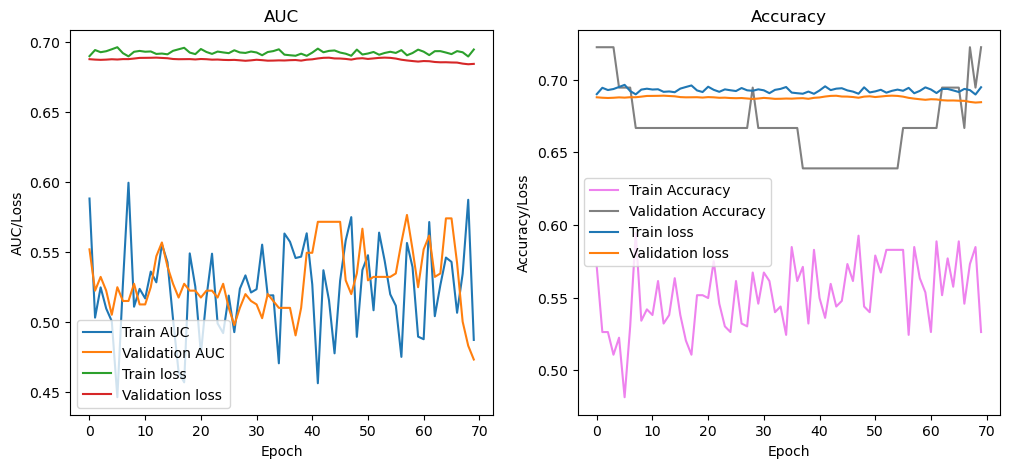

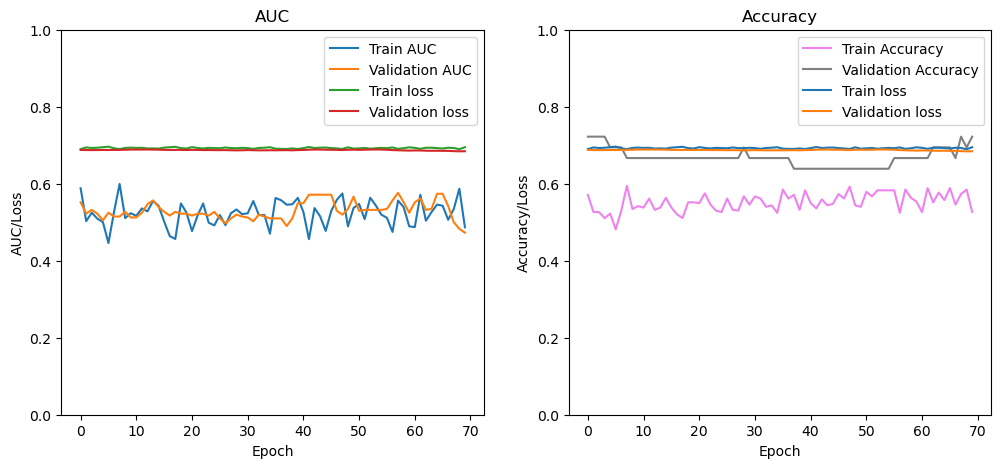

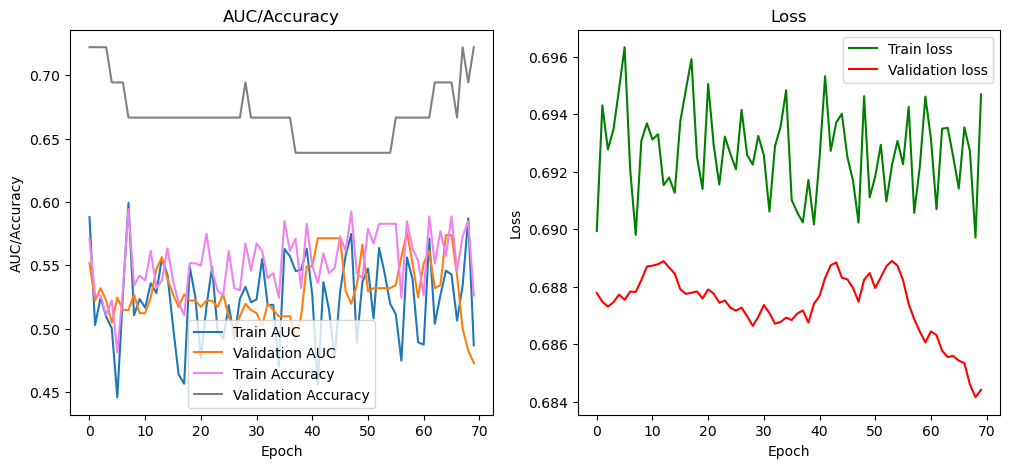

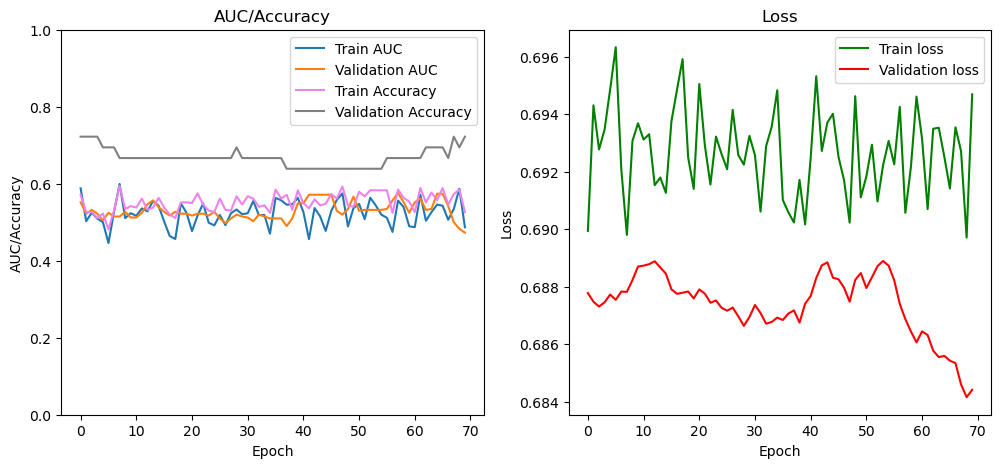

Accuracy: 72.22%
AUC: 61.08%
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 1.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 1.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 1.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 1.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 0.0 Predicted 0
Expected: 1.0 Predicted 0
Expected: 1.0 Predicted 1
Expected: 0.0 Predicted 0
Expected: 1.0 Predicted 0
(513, 599, 2) (36, 599, 2) (513,) (

In [32]:
#MODELO LSTM PROFUNDO ENTRENADO CON LA FFT DE LAS SEÑALES CTG
from keras.callbacks import ModelCheckpoint
matriz = matriz.astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)
matriz = matriz[:,-4800:,:]
matriz_f = fourier(matriz)

seed = 2
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
num = 0

for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

    if fold_num == 11:
        class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
        class_weights = dict(zip(np.unique(y_tr), class_weights))
        input_shape = (x_tr.shape[1], x_tr.shape[2])

        # crear el modelo y cargar los pesos guardados
        model = build_LSTM_model_2(unit_1=30, unit_2=30, reg_1=0.3)
        model.load_weights('Definitivo/LSTM/profundo/11_pesos-01.h5')

        # compilar y entrenar el modelo
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.00001), metrics=['accuracy', 'AUC'])
        history = model.fit(x_tr, y_tr, epochs=70, batch_size=64, verbose=2, class_weight=class_weights, validation_data=(x_te, y_te))

        # evaluar el modelo
        y_pred = model.predict_classes(x_te)
        score, score_1 = metrics.accuracy_score(y_te, y_pred), metrics.roc_auc_score(y_te, y_pred) 
        scores.append(score)
        AUC_scores.append(score_1)

        print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
        print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')

        # graficar la evolución de AUC y pérdida a lo largo de las épocas
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_aUC_4.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_acc_4pdf')
        plt.show()
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("AUC")
        plt.ylabel("AUC/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_aUC_4_1.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.ylim([0,1])
        plt.title("Accuracy")
        plt.ylabel("Accuracy/Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train Accuracy", "Validation Accuracy", "Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_acc_4_1.pdf')
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/LSTMp_4.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_Loss_4.pdf')
        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.plot(history.history["accuracy"], color='violet')
        plt.plot(history.history["val_accuracy"], color='grey')
        plt.ylim([0,1])
        plt.title("AUC/Accuracy")
        plt.ylabel("AUC/Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train AUC", "Validation AUC", "Train Accuracy", "Validation Accuracy"])
        plt.savefig('imagenes/LSTMp_4_1.pdf')

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color='green')
        plt.plot(history.history["val_loss"], color='red')
        plt.title("Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Train loss", "Validation loss"])
        plt.savefig('imagenes/LSTMp_Loss_4_1.pdf')
        plt.show()
        
        from sklearn import metrics
        y_pred = model.predict_classes(x_te)
        # determine the total accuracy 
        accuracy = metrics.accuracy_score(y_te, y_pred)
        AUC = metrics.roc_auc_score(y_te, y_pred)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        print("AUC: %.2f%%" % (AUC * 100.0))
        for i in range(len(y_pred)):
             print('Expected:', y_te[i], 'Predicted', y_pred[i, 0])
        
        
        

        

    fold_num += 1

plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores))

## CURVAS ROC

**Modelo CNN Temporal**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.6486486486486487
Test set AUC score for best params in fold 1 : 0.5642857142857143

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.5405405405405406
Test set AUC score for best params in fold 2 : 0.44285714285714284

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.6486486486486487
Test set AUC score for best params in fold 3 : 0.4547619047619047

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.6486486486486487
Test set AUC score for best params in fold 4 : 0.4

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.6756756756756757
Test set AUC score for best params in fold 5 : 0.5261904761904761

(512, 4800, 2) (37, 4800, 2) (5

Test set accuracy score for best params in fold 9: 0.7297297297297297
Test set AUC score for best params in fold 9 : 0.45

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 10: 0.7222222222222222
Test set AUC score for best params in fold 10 : 0.5566502463054186

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 11: 0.6666666666666666
Test set AUC score for best params in fold 11 : 0.46798029556650245

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.7777777777777778
Test set AUC score for best params in fold 12 : 0.5369458128078817

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.6944444444444444
Test set AUC score for best params in fold 13 : 0.43103448275862066

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.5833333333333334
Test set AUC score for best params in 

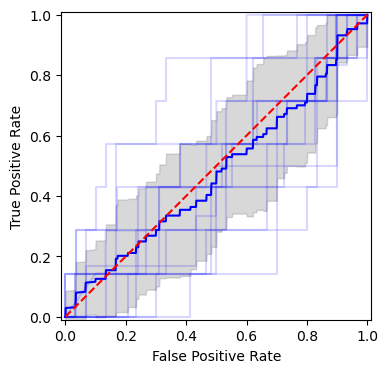

Mean accuracy score: 0.664814814814815
Mean AUC score: 0.47386060937785074
Area bajo la curva: 0.4738155572990408


In [18]:
# Seleccionamos las últimas 4800 columnas de la matriz y la convertimos a float32
matriz = matriz[:,-4800:,:].astype("float32")
# Obtenemos las etiquetas y dividimos en 3 conjuntos: negativos, positivos y total
y, neg, pos = target(etiqueta, 7.15)
# Convertimos el conjunto total a float32 y lo remodelamos para que tenga una dimensión
y = y.astype("float32").reshape(-1)

# Fijamos la semilla para asegurar que los resultados sean reproducibles
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Configuramos los valores iniciales para la curva ROC
tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

# Aplicamos la técnica de validación cruzada estratificada con 15 particiones
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
# Inicializamos variables para guardar los puntajes
fold_num = 1
scores = []
AUC_scores = []

# Inicializamos listas vacías para guardar los valores de fpr y tpr
fpr_list1 = []
tpr_list1 = []

# Iteramos sobre las particiones de train y test generadas por la validación cruzada
for train_index, test_index in skf.split(matriz, y):
    # Seleccionamos los conjuntos de train y test para esta partición
    x_tr, y_tr = matriz[train_index, :, :], y[train_index]
    x_te, y_te = matriz[test_index, :, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    # Calculamos los pesos de clase para esta partición
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    
    # Cargamos el modelo entrenado en la partición de train de esta iteración
    new_model = keras.models.load_model('Definitivo/CNN/Tiempo/7.15/Semilla_'+str(seed)+'/filename_'+str(fold_num)+'.h5')

    # Realizamos predicciones sobre el conjunto de test
    y_pred = new_model.predict(x_te)
        
    # Calculamos los puntajes de accuracy y AUC para esta partición
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    # Calculamos la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    # Calculamos el área bajo la curva (AUC) y la guardamos en la lista
    AUC_scores.append(metrics.auc(fpr, tpr))

    # Graficamos la curva ROC del fold actual
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    # Interpolamos la TPR en los valores de FPR que definimos anteriormente
    tpr = np.interp(base_fpr, fpr, tpr)
    # Aseguramos que el primer valor de TPR sea 0.0
    tpr[0] = 0.0
    # Agregamos los valores de TPR interpolados a la lista
    tprs.append(tpr)
    
    fold_num = fold_num +1


tprs = np.array(tprs) # Convertimos la lista de arrays en un array de numpy
mean_tprs = tprs.mean(axis=0) # Calculamos la media de los arrays a lo largo del eje 0
std = tprs.std(axis=0) # Calculamos la desviación estándar de los arrays a lo largo del eje 0


tprs_upper = np.minimum(mean_tprs + std, 1)# Calculamos el límite superior del intervalo de confianza
tprs_lower = mean_tprs - std # Calculamos el límite inferior del intervalo de confianza

# Graficamos la curva ROC media y el intervalo de confianza
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/CNN_ROC_TIEMPO.pdf')
plt.show()


print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))


**Modelo CNN con transformada de Fourier**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.7297297297297297
Test set AUC score for best params in fold 1 : 0.7238095238095239

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.5135135135135135
Test set AUC score for best params in fold 2 : 0.5357142857142857

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.5135135135135135
Test set AUC score for best params in fold 3 : 0.5904761904761905

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.7567567567567568
Test set AUC score for best params in fold 4 : 0.7404761904761905

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.7027027027027027
Test set AUC score for best params in fold 5 : 0.5428571428571428

(512, 599, 2) (37, 599, 2) 

Test set accuracy score for best params in fold 9: 0.6216216216216216
Test set AUC score for best params in fold 9 : 0.4380952380952381

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 10: 0.5555555555555556
Test set AUC score for best params in fold 10 : 0.5615763546798029

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 11: 0.4722222222222222
Test set AUC score for best params in fold 11 : 0.6182266009852218

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.5277777777777778
Test set AUC score for best params in fold 12 : 0.5443349753694581

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.5
Test set AUC score for best params in fold 13 : 0.5270935960591133

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.6944444444444444
Test set AUC score for best params in fold 14 : 0.7

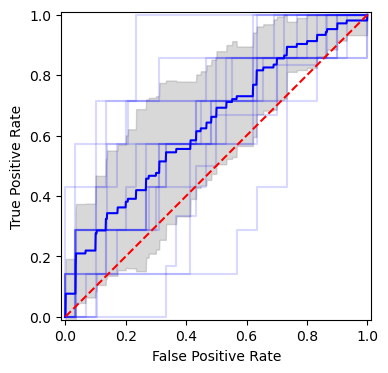

Mean accuracy score: 0.6094594594594595
Mean AUC score: 0.637469439883233
Area bajo la curva: 0.6374072485183595


In [19]:
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)
matriz_f = fourier(matriz)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))

    new_model = keras.models.load_model('Definitivo/CNN/Fourier/7.15/Semilla_'+str(seed)+'/filename_'+str(fold_num)+'.h5')
  
    y_pred = new_model.predict(x_te)
    
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/CNN_ROC_FFT.pdf')
plt.show()



print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo CNN con transformada de Fourier y señales aumentadas**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(549, 4409, 2) (549, 4409, 2)
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 1: 0.6081081081081081
Test set AUC score for best params in fold 1 : 0.5666666666666667

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 2: 0.5405405405405406
Test set AUC score for best params in fold 2 : 0.47023809523809523

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 3: 0.6216216216216216
Test set AUC score for best params in fold 3 : 0.6297619047619047

(1024, 550, 2) (74, 550, 2) (1024,) (74,)


Test set accuracy score for best params in fold 9: 0.5945945945945946
Test set AUC score for best params in fold 9 : 0.44880952380952377

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 10: 0.7361111111111112
Test set AUC score for best params in fold 10 : 0.6194581280788177

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 11: 0.5972222222222222
Test set AUC score for best params in fold 11 : 0.5061576354679803

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 12: 0.6527777777777778
Test set AUC score for best params in fold 12 : 0.4864532019704433

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 13: 0.7638888888888888
Test set AUC score for best params in 

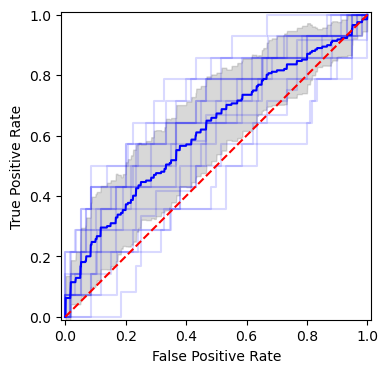

Mean accuracy score: 0.6232982982982983
Mean AUC score: 0.6178430031016239
Area bajo la curva: 0.6178281456059235


In [20]:
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
y, neg, pos =  target(etiqueta, 7.15)
matriz = matriz.astype("float32")
matriz_1 = matriz[:,0:matriz.shape[1]//2:,:]
matriz_2 = matriz[:,matriz.shape[1]//2:,:]  
print(matriz_1.shape, matriz_2.shape)
y_1, neg_1, pos_1 =  target(etiqueta, 7.15)
y_2, neg_2, pos_2 =  target(etiqueta, 7.15)
y_1 = y_1.astype("float32").reshape(-1)
y_2 = y_2.astype("float32").reshape(-1)

matriz_f_1 = fourier(matriz_1)
matriz_f_2 = fourier(matriz_2)


seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr= np.concatenate((matriz_f_1[train_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[train_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_tr = np.concatenate((y_1[train_index], y_2[train_index]), axis=0)
    x_te= np.concatenate((matriz_f_1[test_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[test_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_te = np.concatenate((y_1[test_index], y_2[test_index]), axis=0)
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    input_shape = (x_tr.shape[1], x_tr.shape[2])
    
    new_model = keras.models.load_model('Definitivo/CNN/Ventanas/7.15/Semilla_'+str(seed)+'/filename_'+str(fold_num)+'.h5')

    y_pred = new_model.predict(x_te)
    
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/CNN_ROC_V.pdf')
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo CNN profundo con transformada de Fourier**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.5675675675675675
Test set AUC score for best params in fold 1 : 0.6238095238095238

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.7837837837837838
Test set AUC score for best params in fold 2 : 0.7023809523809523

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.6216216216216216
Test set AUC score for best params in fold 3 : 0.6023809523809524

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.7837837837837838
Test set AUC score for best params in fold 4 : 0.7571428571428572

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.7027027027027027
Test set AUC score for best params in fold 5 : 0.4880952380952381

(512, 599, 2) (37, 599, 2) 

Test set accuracy score for best params in fold 9: 0.6216216216216216
Test set AUC score for best params in fold 9 : 0.49285714285714277

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 10: 0.8055555555555556
Test set AUC score for best params in fold 10 : 0.770935960591133

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 11: 0.6111111111111112
Test set AUC score for best params in fold 11 : 0.5960591133004927

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.6944444444444444
Test set AUC score for best params in fold 12 : 0.48522167487684725

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.8055555555555556
Test set AUC score for best params in fold 13 : 0.7167487684729063

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.7222222222222222
Test set AUC score for best params 

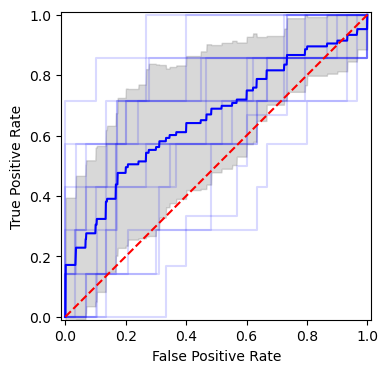

Mean accuracy score: 0.6957957957957959
Mean AUC score: 0.6565389527458493
Area bajo la curva: 0.6564612231278899


In [21]:
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

matriz_f = fourier(matriz)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))

    new_model = keras.models.load_model('Definitivo/CNN/profundo/Semilla_'+str(seed)+'/filename_'+str(fold_num)+'.h5')

    y_pred = new_model.predict(x_te)
    
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/CNN_ROC_P.pdf')
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo LSTM temporal**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.6486486486486487
Test set AUC score for best params in fold 1 : 0.4547619047619047

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.2972972972972973
Test set AUC score for best params in fold 2 : 0.40238095238095234

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.7837837837837838
Test set AUC score for best params in fold 3 : 0.5380952380952381

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.35135135135135137
Test set AUC score for best params in fold 4 : 0.32619047619047614

(512, 4800, 2) (37, 4800, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.3783783783783784
Test set AUC score for best params in fold 5 : 0.39761904761904765

(512, 4800, 2

Test set accuracy score for best params in fold 11: 0.2222222222222222
Test set AUC score for best params in fold 11 : 0.19211822660098524

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.6666666666666666
Test set AUC score for best params in fold 12 : 0.46798029556650245

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.3333333333333333
Test set AUC score for best params in fold 13 : 0.477832512315271

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.3333333333333333
Test set AUC score for best params in fold 14 : 0.4236453201970443

(513, 4800, 2) (36, 4800, 2) (513,) (36,)
Test set accuracy score for best params in fold 15: 0.5555555555555556
Test set AUC score for best params in fold 15 : 0.6



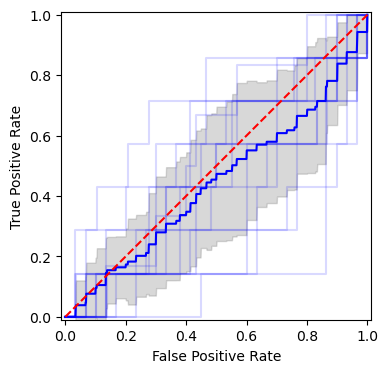

Mean accuracy score: 0.4297797797797797
Mean AUC score: 0.44073526728699136
Area bajo la curva: 0.4407693407693407


In [67]:
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz, y):
    x_tr, y_tr = matriz[train_index, :, :], y[train_index]
    x_te, y_te = matriz[test_index, :, :], y[test_index]
    
    x_tr = x_tr/250
    x_te = x_te/250

    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))

    new_model = keras.models.load_model('Definitivo/LSTM/Tiempo/ph_7.15/Semilla_1/Semilla'+str(seed)+'filename_'+str(fold_num)+'.h5')

    y_pred = new_model.predict(x_te)

    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/LSTM_ROC_TIEMPO.pdf')
plt.show()



print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo LSTM con transformada de Fourier**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.6756756756756757
Test set AUC score for best params in fold 1 : 0.6904761904761906

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.5135135135135135
Test set AUC score for best params in fold 2 : 0.4261904761904761

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.5405405405405406
Test set AUC score for best params in fold 3 : 0.4976190476190476

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.6486486486486487
Test set AUC score for best params in fold 4 : 0.6738095238095239

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.5135135135135135
Test set AUC score for best params in fold 5 : 0.4809523809523809

(512, 599, 2) (37, 599, 2) 

Test set accuracy score for best params in fold 9: 0.6486486486486487
Test set AUC score for best params in fold 9 : 0.7285714285714286

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 10: 0.6111111111111112
Test set AUC score for best params in fold 10 : 0.541871921182266

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 11: 0.5555555555555556
Test set AUC score for best params in fold 11 : 0.4532019704433497

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.5833333333333334
Test set AUC score for best params in fold 12 : 0.6330049261083744

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.5833333333333334
Test set AUC score for best params in fold 13 : 0.4704433497536945

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.4444444444444444
Test set AUC score for best params in

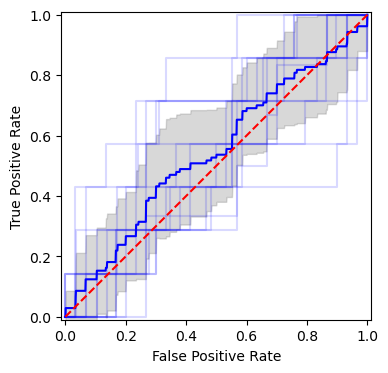

Mean accuracy score: 0.5845845845845845
Mean AUC score: 0.5443970078452837
Area bajo la curva: 0.5443729443729444


In [68]:
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)
matriz_f = fourier(matriz)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]

    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))

    new_model = keras.models.load_model('Definitivo/LSTM/fourier/ph_7.15/Semilla_'+str(seed)+'filename_12.h5')

    y_pred = new_model.predict(x_te)

    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/LSTM_ROC_FFT.pdf')
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo LSTM con transformada de Fourier y señales aumentadas**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(549, 4409, 2) (549, 4409, 2)
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 1: 0.5675675675675675
Test set AUC score for best params in fold 1 : 0.569047619047619

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 2: 0.6486486486486487
Test set AUC score for best params in fold 2 : 0.5916666666666666

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(1024, 550, 2) (74, 550, 2) (1024,) (74,)
Test set accuracy score for best params in fold 3: 0.2972972972972973
Test set AUC score for best params in fold 3 : 0.48452380952380947

(1024, 550, 2) (74, 550, 2) (1024,) (74,)
(

Test set accuracy score for best params in fold 9: 0.36486486486486486
Test set AUC score for best params in fold 9 : 0.5809523809523809

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 10: 0.6111111111111112
Test set AUC score for best params in fold 10 : 0.48768472906403937

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 11: 0.5972222222222222
Test set AUC score for best params in fold 11 : 0.560344827586207

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 12: 0.5833333333333334
Test set AUC score for best params in fold 12 : 0.4433497536945813

(1026, 550, 2) (72, 550, 2) (1026,) (72,)
(1026, 550, 2) (72, 550, 2) (1026,) (72,)
Test set accuracy score for best params in fold 13: 0.3333333333333333
Test set AUC score for best params in 

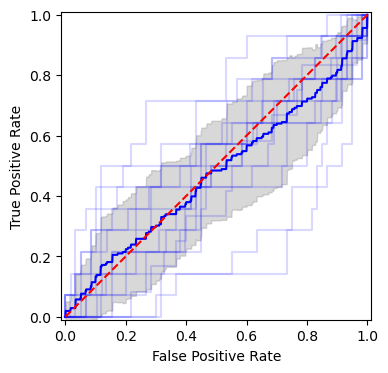

Mean accuracy score: 0.4724974974974975
Mean AUC score: 0.47305509943440976
Area bajo la curva: 0.473051623051623


In [24]:
matriz = np.load('matriz_def.npy')
etiqueta = np.load('etiquetas_def.npy')
y, neg, pos =  target(etiqueta, 7.15)
matriz = matriz.astype("float32")
matriz_1 = matriz[:,0:matriz.shape[1]//2:,:]
matriz_2 = matriz[:,matriz.shape[1]//2:,:]  
print(matriz_1.shape, matriz_2.shape)
y_1, neg_1, pos_1 =  target(etiqueta, 7.15)
y_2, neg_2, pos_2 =  target(etiqueta, 7.15)
y_1 = y_1.astype("float32").reshape(-1)
y_2 = y_2.astype("float32").reshape(-1)

matriz_f_1 = fourier(matriz_1)
matriz_f_2 = fourier(matriz_2)


seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr= np.concatenate((matriz_f_1[train_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[train_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_tr = np.concatenate((y_1[train_index], y_2[train_index]), axis=0)
    x_te= np.concatenate((matriz_f_1[test_index, 1:matriz_f_1.shape[1]//4, :], 
                          matriz_f_2[test_index, 1:matriz_f_2.shape[1]//4, :]),axis=0)
    y_te = np.concatenate((y_1[test_index], y_2[test_index]), axis=0)
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))
    
    input_shape = (x_tr.shape[1], x_tr.shape[2])
    new_model = keras.models.load_model('Definitivo/LSTM/ventanas/ph_7.15/Semilla_'+str(seed)+'filename_'+str(fold_num)+'.h5')

    y_pred = new_model.predict(x_te)
    
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/LSTM_ROC_V.pdf')
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

**Modelo LSTM profundo con transformada de Fourier**

Muestras sin hipoxia: 445 81.05646630236795
Muestras con hipoxia: 104 18.94353369763206
(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 1: 0.5405405405405406
Test set AUC score for best params in fold 1 : 0.5523809523809524

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 2: 0.5945945945945946
Test set AUC score for best params in fold 2 : 0.4761904761904762

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 3: 0.35135135135135137
Test set AUC score for best params in fold 3 : 0.380952380952381

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 4: 0.5945945945945946
Test set AUC score for best params in fold 4 : 0.4761904761904762

(512, 599, 2) (37, 599, 2) (512,) (37,)
Test set accuracy score for best params in fold 5: 0.5135135135135135
Test set AUC score for best params in fold 5 : 0.3714285714285714

(512, 599, 2) (37, 599, 2) 

Test set accuracy score for best params in fold 9: 0.6486486486486487
Test set AUC score for best params in fold 9 : 0.4547619047619047

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 10: 0.5555555555555556
Test set AUC score for best params in fold 10 : 0.4532019704433497

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 11: 0.6666666666666666
Test set AUC score for best params in fold 11 : 0.5763546798029557

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 12: 0.3055555555555556
Test set AUC score for best params in fold 12 : 0.3522167487684729

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 13: 0.6666666666666666
Test set AUC score for best params in fold 13 : 0.46798029556650245

(513, 599, 2) (36, 599, 2) (513,) (36,)
Test set accuracy score for best params in fold 14: 0.5277777777777778
Test set AUC score for best params 

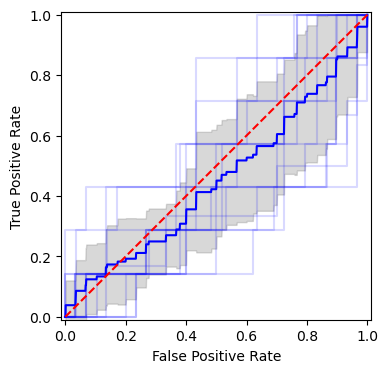

Mean accuracy score: 0.5371371371371371
Mean AUC score: 0.4509067688378033
Area bajo la curva: 0.4509461842795176


In [25]:
matriz = matriz[:,-4800:,:].astype("float32")
y, neg, pos =  target(etiqueta, 7.15)
y = y.astype("float32").reshape(-1)

matriz_f = fourier(matriz)

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

tprs = []
base_fpr = np.linspace(0, 1, 1000)
plt.figure(figsize=(4,4))
plt.axes().set_aspect('equal', 'datalim')

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_num = 1
scores = []
AUC_scores = []

fpr_list1 = []
tpr_list1 = []

for train_index, test_index in skf.split(matriz_f, y):
    x_tr, y_tr = matriz_f[train_index, 1:matriz_f.shape[1]//4, :], y[train_index]
    x_te, y_te = matriz_f[test_index, 1:matriz_f.shape[1]//4, :], y[test_index]
    print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)
    
    class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_tr), y = y_tr)
    class_weights = dict(zip(np.unique(y_tr), class_weights))

    new_model = keras.models.load_model('Definitivo/LSTM/profundo/Semilla_'+str(seed)+'filename_'+str(fold_num)+'.h5')

    y_pred = new_model.predict(x_te)
    
    score, score_1 = metrics.accuracy_score(y_te, np.around(y_pred)), metrics.roc_auc_score(y_te, np.around(y_pred)) 
    scores.append(score)

    print(f"Test set accuracy score for best params in fold {fold_num}: {score}")
    print(f'Test set AUC score for best params in fold {fold_num} : {score_1}\n')
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    
    AUC_scores.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    fold_num = fold_num +1

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('imagenes/LSTM_ROC_P.pdf')
plt.show()

print(f'Mean accuracy score:',np.mean(scores))
print(f'Mean AUC score:',np.mean(AUC_scores)) 
print(f'Area bajo la curva:',metrics.auc(base_fpr, mean_tprs))

## GRÁFICA DE RESUMEN

In [6]:
ACC_liminf = [0.5277777777777778, 0.4722222222222222, 0.5405405405405406, 0.5277777777777778, 0.2222222222222222, 0.4444444444444444, 0.17567567567567569, 0.3055555555555556]
ACC_limsup = [0.7837837837837838, 0.7837837837837838, 0.7638888888888888, 0.8055555555555556, 0.7837837837837838, 0.7567567567567568, 0.7297297297297297, 0.6666666666666666]
AUC_liminf =[0.4, 0.4380952380952381, 0.44880952380952377, 0.44999999999999996, 0.19211822660098524, 0.40952380952380946, 0.20476190476190476, 0.3214285714285714]
AUC_limsup = [0.6476190476190476, 0.7404761904761905, 0.6869047619047619, 0.7952380952380953, 0.6, 0.7285714285714286, 0.5916666666666666, 0.5763546798029557 ]
ACC = [0.681006006006006, 0.6094594594594595, 0.6232982982982983, 0.6957957957957959, 0.4297797797797797, 0.5845845845845845, 0.4724974974974975, 0.5371371371371371]
AUC = [0.5100574712643677, 0.637469439883233, 0.6178430031016239, 0.6565389527458493, 0.44073526728699136, 0.5443970078452837, 0.47305509943440976, 0.4509067688378033]
LIMinf_ACC = []
LIMsup_ACC = []
LIMinf_AUC = []
LIMsup_AUC = []
for i in range(0,8):
    LIMinf_ACC.append(ACC[i] - ACC_liminf[i])
    LIMinf_AUC.append(AUC[i] - AUC_liminf[i])
    LIMsup_ACC.append(ACC_limsup[i] - ACC[i])
    LIMsup_AUC.append(AUC_limsup[i] - AUC[i])
print(LIMinf_ACC,
LIMsup_ACC,
LIMinf_AUC,
LIMsup_AUC)

[0.15322822822822824, 0.13723723723723724, 0.08275775775775773, 0.16801801801801808, 0.2075575575575575, 0.1401401401401401, 0.2968218218218218, 0.23158158158158149] [0.10277777777777775, 0.17432432432432432, 0.14059059059059054, 0.10975975975975971, 0.35400400400400406, 0.1721721721721723, 0.25723223223223224, 0.12952952952952956] [0.11005747126436771, 0.19937420178799492, 0.1690334792921001, 0.20653895274584932, 0.24861704068600612, 0.1348731983214742, 0.268293194672505, 0.1294781974092319] [0.13756157635467992, 0.1030067505929575, 0.06906175880313803, 0.13869914249224602, 0.15926473271300862, 0.18417442072614498, 0.1186115672322568, 0.12544791096515245]


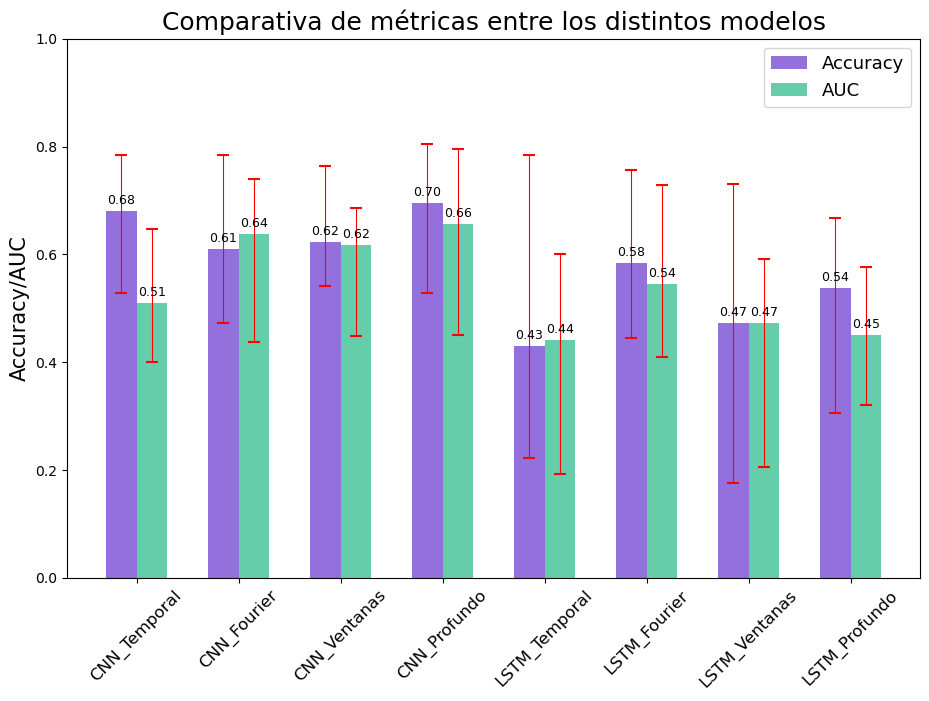

In [8]:
# Creamos un DataFrame con los datos de Accuracy y AUC de los distintos modelos
data = pd.DataFrame({'Accuracy' : [0.681006006006006, 0.6094594594594595, 0.6232982982982983, 0.6957957957957959, 0.4297797797797797, 0.5845845845845845, 0.4724974974974975, 0.5371371371371371],
                     'AUC': [0.5100574712643677, 0.637469439883233, 0.6178430031016239, 0.6565389527458493, 0.44073526728699136, 0.5443970078452837, 0.47305509943440976, 0.4509067688378033]},
                    index=('CNN_Temporal', 'CNN_Fourier', 'CNN_Ventanas', 'CNN_Profundo', 'LSTM_Temporal', 'LSTM_Fourier', 'LSTM_Ventanas', 'LSTM_Profundo'))

n = len(data.index) # Número de modelos
x = np.arange(n) # Coordenadas en el eje x para cada modelo
width = 0.3 # Ancho de cada barra

# Creamos la figura y los ejes del gráfico
plt.figure(figsize=(11,7))
# Creamos las barras para Accuracy
rects1 = plt.bar(x - width/2, data.Accuracy, width=width, label='Accuracy', color = 'mediumpurple')
# Añadimos las barras de error para Accuracy
plt.errorbar(x - width/2, data.Accuracy, yerr=[LIMinf_ACC, LIMsup_ACC], fmt='None', ecolor='red', elinewidth=0.8, capsize=4, capthick=1.5)

# Creamos las barras para AUC
rects2 = plt.bar(x + width/2, data.AUC, width=width, label='AUC', color = 'mediumaquamarine')
# Añadimos las barras de error para AUC
plt.errorbar(x + width/2, data.AUC, yerr=[LIMinf_AUC, LIMsup_AUC], fmt='None', ecolor='red', elinewidth=0.8, capsize=4, capthick=1.5)

 
plt.xticks(x, data.index, rotation=45, fontsize=12) # Establecemos la ubicación, rotación y tamaño de las etiquetas del eje x
plt.ylabel('Accuracy/AUC', fontsize=15) # Establecemos la etiqueta del eje y
plt.title('Comparativa de métricas entre los distintos modelos', fontsize=18)

def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.2f}'.format(height), fontsize=9, # Formatear a dos decimales
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)

# Establecemos el rango del eje y
plt.ylim([0,1])
# Establecemos la leyenda y su ubicación
plt.legend(loc='best', fontsize=13)
# Guardamos la figura en un archivo y la mostramos
plt.savefig('imagenes/FINAL.pdf', bbox_inches='tight')
plt.show()                     